# Study on Drug and Alcohol Involvement in U.S. Fatal Traffic Accidents (2018–2023)

**Group 5:** Pedro Fanica (54346), Rafael Gufler (66081),  Aarthi Perumpillichira (66404), Amadeus Rieck (66030)
**Course**: Foundations of Data Science (FCD) - Masters in Data Science 2025/26
**Institution**: Faculdade de Ciências da Universidade de Lisboa

---
---

## Project Introduction

This notebook outlines the entire data science pipeline, from data ingestion to predictive model training, using the **Fatal Accident Reporting System (FARS)** dataset (2018, 2019, 2022, 2023).

### **Dataset: Fatality Analysis Reporting System (FARS)**

* **Source**:  National Highway Traffic Safety Administration (NHTSA)
* **Scope**: Census of all fatal motor vehicle traffic crashes in the U.S. (national level).
* **Description**: FARS is the official U.S. source, compiled from detailed police reports and toxicology results (tables: `accident`, `person`, `drugs`).
* **Data Access**:
  * **Official Repository**: [NHTSA website with FARS reports](https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/) (Contains raw CSV/SAS files per year).
  * **Documentation**: [FARS Analytical User’s Manual](/docs/FARS_user_manual_1975_2023.pdf) (Dataset metadata), obtained through the following [link](https://crashstats.nhtsa.dot.gov/Api/Public/ViewPublication/813706).

  * **Repository**: the full repository is available at: [GitHub - PFans-201/US_accidents_project](https://github.com/PFans-201/US_accidents_project)

---
### Table of Contents 

1.  **Data Loading**: Load and select `accident`, `person`, and `drugs` datasets from FARS national archive for 2018, 2019 and 2023.
2.  **Data Cleaning and Preprocessing**: Handle missing values, create new features, and prepare data for analysis.
3.  **Exploratory Data Analysis (EDA)**: Analyze temporal trends, spatial hotspots, and impairment distributions.
4.  **Preprocessing and Feature Selection**: Final data preparation steps, and feature selection for modeling.
5.  **Machine Learning Pipeline**: Transform data, train models, and evaluate performance. LIME explanations to interpret black-box model predictions.

## 0. Environment Setup

NOTE: When using Google Coolab, run this first

In [2]:
%pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 5.9 MB/s eta 0:00:00


In [38]:
# Core Data science
import pandas as pd
import numpy as np
import sklearn as sk
import joblib

# Modeling, missing data handling and feature engineering

from scipy.stats import norm
from category_encoders import WOEEncoder
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from lime.lime_tabular import LimeTabularExplainer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Other utilities
from pathlib import Path
import shutil
import os

print("✓ Required packages imported")

✓ Required packages imported


In [4]:
# Setup
sns.set_style('whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Helper function:
def rel_path(target_path: Path) -> str:
    """
    Returns the path relative to the current working directory (project root),
    prefixed with the project directory name.
    """
    try:
        file_abs = target_path.resolve() # Convert input to absolute path
        root = Path.cwd() # Get the current working directory (Project Root)
        rel_part = file_abs.relative_to(root) # Calculate the path relative to root
       
        return f"/{root.name}/{rel_part.as_posix()}" # Combination

    except ValueError:
        # Happens if the file is NOT inside the project root
        return target_path.as_posix()
    except Exception:
        return str(target_path)

print("✓ Environment setup complete")

✓ Environment setup complete


## 1. Data Loading

### 1.1. Selection of years and datasets to load

In [25]:
# --- Configuration ---
RAW_DATA_PATH = Path("data/raw/") 
FARS_SELECTED = RAW_DATA_PATH / "FARS_SELECTED"
FILES_OF_INTEREST = ["accident.csv", "person.csv", "drugs.csv"]

def get_file_info(file_path):
    """
    Helper to get file size in MB and row count.
    Uses a generator to count lines to avoid loading the whole file into RAM.
    """
    # 1. Get Size
    size_bytes = file_path.stat().st_size
    size_mb = size_bytes / (1024 * 1024)
    
    # 2. Get Rows (Fast line count)
    # We subtract 1 because of the header.
    # We use ISO-8859-1 because FARS data often has legacy encoding.
    try:
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            row_count = sum(1 for _ in f) - 1
    except Exception:
        row_count = "Unknown"

    return f"{size_mb:.2f} MB", row_count

def select_data():
    """
    Iterates through raw year folders, finds specific CSVs,
    saves them as filename_year.csv, and logs size/rows.
    """
    print("--- Starting Data Selection Process ---")
    FARS_SELECTED.mkdir(parents=True, exist_ok=True)
    rel_raw = rel_path(RAW_DATA_PATH)
    # 1. Map years to folders
    year_folder_map = {}
    if RAW_DATA_PATH.exists():
        for folder in RAW_DATA_PATH.glob("FARS*"):
            if folder.is_dir():
                digits = ''.join(filter(str.isdigit, folder.name))
                if digits:
                    year_folder_map[int(digits)] = folder
    else:
        print(f"Error: Raw data path {rel_raw} not found.")
        return

    available_years = sorted(year_folder_map.keys())
    print(f"Found {len(available_years)} years of raw data: {available_years}")

    # 2. Process each file type for each year
    for year in available_years:
        src_folder = year_folder_map[year]
        
        for filename in FILES_OF_INTEREST:
            # Case-insensitive search for the file
            matches = [f for f in src_folder.rglob("*") if f.name.lower() == filename.lower()]

            if matches:
                source_file = matches[0]
                
                # Construct new filename: accident.csv -> accident_1975.csv
                stem = Path(filename).stem
                suffix = Path(filename).suffix
                new_filename = f"{stem}_{year}{suffix}"
                dest_path = FARS_SELECTED / new_filename
                
                try:
                    # Copy the file
                    shutil.copy(source_file, dest_path)
                    
                    # Calculate Stats for the Print Statement
                    size_str, rows = get_file_info(dest_path)
                    
                    print(f"  - Saved: {new_filename}\n     -- Size {size_str}, rows {rows}")
                    
                except Exception as e:
                    print(f"  Error processing {filename} for {year}: {e}")
            else:
                # pass silently if file missing
                pass

def validate_data():
    """
    Checks FARS_SELECTED to see which years exist for each file type
    """
    rel_fars = rel_path(FARS_SELECTED)
    print(f"\n--- Checking Selected Data in {rel_fars} ---")
    
    if not FARS_SELECTED.exists():
        print("Destination directory does not exist.")
        return

    for base_filename in FILES_OF_INTEREST:
        stem = Path(base_filename).stem 
        found_files = list(FARS_SELECTED.glob(f"{stem}_*.csv"))
        
        years_found = []
        for f in found_files:
            try:
                year_part = f.stem.split('_')[-1]
                if year_part.isdigit():
                    years_found.append(int(year_part))
            except:
                pass
        
        years_found.sort()
        
        if years_found:
            print(f"Type: {base_filename}")
            print(f"  - Years found: {years_found}")
            print( "  - Data present: Yes")
        else:
            print(f"Type: {base_filename} - No files found.")

# --- Main Execution Flow ---

if FARS_SELECTED.exists() and any(FARS_SELECTED.iterdir()):
    print("Folder with selected datasets already exists.")
    validate_data()
else:
    print("Destination empty or missing. Starting ETL process...")
    select_data()
    validate_data()

Destination empty or missing. Starting ETL process...
--- Starting Data Selection Process ---
Found 3 years of raw data: [2018, 2019, 2023]
  - Saved: accident_2018.csv
     -- Size 22.34 MB, rows 33919
  - Saved: person_2018.csv
     -- Size 84.02 MB, rows 84344
  - Saved: drugs_2018.csv
     -- Size 5.72 MB, rows 99097
  - Saved: accident_2019.csv
     -- Size 22.66 MB, rows 33487
  - Saved: person_2019.csv
     -- Size 86.78 MB, rows 82843
  - Saved: drugs_2019.csv
     -- Size 5.70 MB, rows 98899
  - Saved: accident_2023.csv
     -- Size 22.87 MB, rows 37654
  - Saved: person_2023.csv
     -- Size 106.71 MB, rows 92400
  - Saved: drugs_2023.csv
     -- Size 19.67 MB, rows 129629

--- Checking Selected Data in /US_accidents_project/data/raw/FARS_SELECTED ---
Type: accident.csv
  - Years found: [2018, 2019, 2023]
  - Data present: Yes
Type: person.csv
  - Years found: [2018, 2019, 2023]
  - Data present: Yes
Type: drugs.csv
  - Years found: [2018, 2019, 2023]
  - Data present: Yes


In [26]:
# --- Configuration ---
RAW_DATA_PATH = Path("data/raw/") 
FARS_SELECTED = RAW_DATA_PATH / "FARS_SELECTED"
# We define these to know what to look for in the summary report
SELECTED_DATA = ["accident", "person", "drugs"]

def optimize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Optimizes data types to save memory and ensure logical consistency.
    """
    # 1. Convert to nullable types (Int64, string, boolean)
    df = df.convert_dtypes()

    # 2. Downcast Numeric Columns
    for col in df.select_dtypes(include=['number']):
        df[col] = pd.to_numeric(df[col], downcast='integer')
        if df[col].dtype == 'float64':
            df[col] = pd.to_numeric(df[col], downcast='float')

    # 3. Convert Low-Cardinality Strings/Objects to Categories
    for col in df.select_dtypes(include=['string', 'object']):
        num_unique = df[col].nunique()
        num_total = len(df)
        if num_total > 0 and (num_unique / num_total) < 0.5:
            df[col] = df[col].astype('category')
            
    return df

def load_fars_dictionary():
    """
    Scans the FARS_SELECTED folder and builds a nested dictionary:
    fars_data[year][data_type] = DataFrame
    """
    fars_data = {}
    
    print(f"--- Loading FARS CSV files from {FARS_SELECTED} ---\n")
    
    if not FARS_SELECTED.exists():
        print("❌ Error: FARS_SELECTED directory not found.")
        return {}

    # 1. Find all CSVs
    all_files = list(FARS_SELECTED.glob("*.csv"))
    
    if not all_files:
        print("⚠️ No CSV files found.")
        return {}

    # 2. Loop through every file found
    for csv_file in all_files:
        try:
            # Filename format: "accident_1975.csv"
            base_name = csv_file.stem
            
            # Split into Type and Year
            parts = base_name.rsplit('_', 1) 
            
            if len(parts) != 2:
                print(f"  Skipping {csv_file.name} (does not match 'name_year' format)")
                continue
                
            data_type = parts[0]  # e.g., "accident"
            year_str = parts[1]   # e.g., "1975"
            
            if not year_str.isdigit():
                continue
                
            year = int(year_str)

            # Initialize dictionary for this year if it doesn't exist yet
            if year not in fars_data:
                fars_data[year] = {}

            # Load the DataFrame
            df = pd.read_csv(
                csv_file, 
                low_memory=False, 
                encoding='ISO-8859-1'
            )
            
            # Optimization step
            fars_data[year][data_type] = optimize_dataframe(df)

        except Exception as e:
            print(f"❌ Error reading {csv_file.name}: {e}")

    print(f"Finished loading {len(all_files)} files!\n")
    return fars_data

# --- Execute Loading ---
fars_data = load_fars_dictionary()

# --- Print Overview ---
if fars_data:
    print("FARS Data Overview:")
    
    # Sort years so the report is chronological
    available_years = sorted(fars_data.keys())
    
    for year in available_years:
        print(f"\nFARS data for year {year}:")
        
        for dataset in SELECTED_DATA:
            if dataset not in fars_data[year]:
                print(f"  - {dataset}: Not available")
                continue
            
            df = fars_data[year][dataset]
            print(f"  - {dataset}, shape: {df.shape}")
            
            # Optimization: Only printing first 10 columns to avoid massive output
            cols = df.columns.tolist()
            if len(cols) > 10:
                print(f"    - columns ({len(cols)} total): {cols[:10]} ...")
            else:
                print(f"    - columns: {cols}")
else:
    print("No data loaded.")

--- Loading FARS CSV files from data/raw/FARS_SELECTED ---

Finished loading 9 files!

FARS Data Overview:

FARS data for year 2018:
  - accident, shape: (33919, 91)
    - columns (91 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERSONS', 'PERMVIT', 'PERNOTMVIT'] ...
  - person, shape: (84344, 118)
    - columns (118 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'STR_VEH', 'COUNTY', 'DAY', 'DAYNAME'] ...
  - drugs, shape: (99097, 9)
    - columns: ['STATE', 'STATENAME', 'ST_CASE', 'VEH_NO', 'PER_NO', 'DRUGSPEC', 'DRUGSPECNAME', 'DRUGRES', 'DRUGRESNAME']

FARS data for year 2019:
  - accident, shape: (33487, 91)
    - columns (91 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PEDS', 'PERSONS', 'PERMVIT', 'PERNOTMVIT'] ...
  - person, shape: (82843, 119)
    - columns (119 total): ['STATE', 'STATENAME', 'ST_CASE', 'VE_FORMS', 'VEH_NO', 'PER_NO', 'STR_VEH', 'COUNTY', 'DAY', 'DAYNAME'] ...

In [27]:
# Example by accessing the 'drugs' dataset for the year 2023
fars_data[2023]['drugs'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129629 entries, 0 to 129628
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   STATE           129629 non-null  Int8    
 1   STATENAME       129629 non-null  category
 2   ST_CASE         129629 non-null  Int32   
 3   VEH_NO          129629 non-null  Int8    
 4   PER_NO          129629 non-null  Int8    
 5   DRUGSPEC        129629 non-null  Int8    
 6   DRUGSPECNAME    129629 non-null  category
 7   DRUGMETHOD      129629 non-null  Int8    
 8   DRUGMETHODNAME  129629 non-null  category
 9   DRUGRES         129629 non-null  Int16   
 10  DRUGRESNAME     129629 non-null  category
 11  DRUGQTY         129629 non-null  Int8    
 12  DRUGQTYNAME     129629 non-null  category
 13  DRUGACTQTY      129629 non-null  Float64 
 14  DRUGACTQTYNAME  129629 non-null  category
 15  DRUGUOM         129629 non-null  Int8    
 16  DRUGUOMNAME     129629 non-null  categ

In [ ]:
# for data_type in SELECTED_DATA:
#     print(f"\nFARS {data_type} sample:")
#     for year in available_years:
#         if data_type not in fars_data[year]:
#             print(f"  - {data_type} data in {year}: Not available")
#             continue
#         df = fars_data[year][data_type]
#         print(f"  - {data_type} {year}, shape: {df.shape}")
#         display(df.head(2))

<a id="init_feat_selec"></a>
### 1.2. Initial feature selection per dataset (data_type)

We aim to select a subset of features from each dataset that are relevant to our analysis of drug and alcohol involvement in fatal traffic accidents. The selected features will help us understand the circumstances surrounding these accidents, the demographics of those involved, and the outcomes.

We must understand the structure of each dataset and the meaning of each feature. The FARS Analytical User’s Manual will be a crucial resource for this task. 

Features might change depending on the year, so we will need to account for any differences in feature names or coding schemes across years.

In [28]:
# Keep only columns of interest/drop unimportant columns, 
# further feature selection will be held downstream

SELECTED_COLS = {
    'accident':[
        'ST_CASE', 'STATENAME', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT',
        'COUNTYNAME', 'MONTH', 'DAY', 'DAY_WEEKNAME', 'YEAR', 'HOUR', 'MINUTE', 'TWAY_ID', 'ROUTENAME',
        'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'NHSNAME', 'SP_JURNAME', 'HARM_EVNAME',
        'MAN_COLLNAME', 'RELJCT2NAME', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONE', 'LGT_CONDNAME', 'WEATHERNAME',
        'SCH_BUSNAME', 'RAIL', 'NOT_HOUR', 'NOT_MIN', 'FATALS'
        ],
    'drugs'   :['ST_CASE', 'PER_NO', 'DRUGRESNAME'],
    'person'  :['ST_CASE', 'PER_NO', 'AGE', 'PER_TYP', 'DRINKING', 'INJ_SEV', 'ALC_RES'] 
}

# Fast check if SELECTED_COLS exist across all years
for data_type, columns in SELECTED_COLS.items():
    print(f"\nChecking columns for dataset: {data_type}")
    for year in available_years:
        if data_type not in fars_data[year]:
            print(f"  - {data_type} data in {year}: Not available")
            continue
        
        df = fars_data[year][data_type]
        missing_cols = [col for col in columns if col not in df.columns]
        
        if missing_cols:
            print(f"  - Year {year}: Missing columns: {missing_cols}")
        else:
            print(f"  - Year {year}: All columns present")


Checking columns for dataset: accident
  - Year 2018: All columns present
  - Year 2019: All columns present
  - Year 2023: All columns present

Checking columns for dataset: drugs
  - Year 2018: All columns present
  - Year 2019: All columns present
  - Year 2023: All columns present

Checking columns for dataset: person
  - Year 2018: All columns present
  - Year 2019: All columns present
  - Year 2023: All columns present


In [29]:
# filter only selected columns
for data_type, columns in SELECTED_COLS.items():
    for year in available_years:
        if data_type not in fars_data[year]:
            continue
        df = fars_data[year][data_type]
        fars_data[year][data_type] = df[columns]


---

## 2. Data Cleaning and Preprocessing

In [ ]:
# Missing values analysis and remapping
missing = pd.DataFrame({
        'Column': [],
        'Missing_Count': [],
        'Missing_Percentage': []
    })

remap_vals = {
    'ROUTENAME': {
        'County': 'County Road',
        'Township': 'Local Street - Township',
        'Municipal': 'Local Street - Municipality',
        'Local Street - Frontage Road': 'Other',
        'Parkway Marker or Forest Route Marker [Specify:]': 'Other',
        'Off-Interstate Business Marker': 'Other',
        'Secondary Route': 'Other',
        'Bureau of Indian Affairs': 'Other'
        },
    'FUNC_SYSNAME': {
        'Other Freeways and Expressways': 'Principal Arterial - Other Freeways and Expressways',
        'Other Principal Arterial': 'Principal Arterial - Other'
        },
    'MAN_COLLNAME': {
        'First Harmful Event was Not a Collision with Motor Vehicle In-Transport': 'Not a Collision with Motor Vehicle In-Transport'
        },
    'DRUGRESNAME': {
        'Narcotic Analgesics': 'Narcotics',
        'Phencyclidine (PCP)': 'Other Drug (Specify:)',
        'Dissociative Anesthetics': 'Other Drug (Specify:)',
        'Non-Psychoactive/Other Drugs': 'None Detected/Below Threshold',
    }
}

missing_vals = {
    'HOUR': [99],
    'MINUTE': [99],
    'TWAY_ID': [999999999999999999999999999999],
    'ROUTENAME': ['Unknown/Not Reported', 'Trafficway Not in State Inventory', 'Unknown'], #Changes 2023
    'RUR_URBNAME': [6, 8, 9],
    'FUNC_SYSNAME': [96, 98, 99], #Changes 2023
    'RD_OWNERNAME': [96, 98, 99],
    'NHSNAME': [9],
    'SP_JURNAME': [9],
    'HARM_EVNAME': ['Reported as Unknown'],
    'MAN_COLLNAME': ['Unknown'], #Changes 2019
    'RELJCT2NAME': ['Reported as Unknown', 'Not Reported'],
    'TYP_INTNAME': ['Reported as Unknown', 'Not Reported'], #Changes 2020
    'REL_ROADNAME': ['Reported as Unknown', 'Not Reported'],
    'LGT_CONDNAME': ['Other', 'Not Reported', 'Reported as Unknown'],
    'WEATHERNAME': ['Not Reported', 'Unknown', 'Reported as Unknown'],
    'RAIL': ['9999999'],
    'NOT_HOUR': [88, 99],
    'NOT_MIN': [88, 98, 99],
    'ALC_RES': [999], #Needs more than just dealing with missing values
    'INJ_SEV': [9],
    'AGE': [998, 999], # Maximum age is 120, other values 'Not Reported' and 'Reported as Unknown', respectively
    'DRUGRESNAME': ['Reported as Unknown if Tested for Drugs', 'Tested for Drugs, Results Unknown', 'Tested for Drug, Results Unknown', 'Not Reported'], #Changes 2022
}

for data_type in SELECTED_DATA:
    for year in available_years:
        dataset = fars_data[year][data_type]
        for column in dataset.columns:
            if (column in remap_vals or column in missing_vals) and isinstance(dataset[column].dtype, pd.CategoricalDtype):
                dataset[column] = dataset[column].astype('object')
            if column in remap_vals:
                for value in remap_vals[column]:
                    dataset.loc[dataset[column] == value, column] = remap_vals[column][value]
            if column in missing_vals:
                for value in missing_vals[column]:
                    dataset.loc[dataset[column] == value, column] = None

print("Remapped non-missing values & replaced missing values")


Remapped non-missing values & replaced missing values


Columns with missing values: 17 out of 46

Columns with missing data:


,Dataset,Column,Missing_Count,Missing_Percentage
12,accident,NOT_MIN,56757,54.02
11,accident,NOT_HOUR,55546,52.87
16,drugs,DRUGRESNAME,32504,9.92
9,accident,WEATHERNAME,6574,6.26
3,accident,ROUTENAME,4737,4.51
13,person,AGE,6155,2.37
14,person,INJ_SEV,3647,1.40
1,accident,MINUTE,753,0.72
0,accident,HOUR,752,0.72
15,person,ALC_RES,1844,0.71


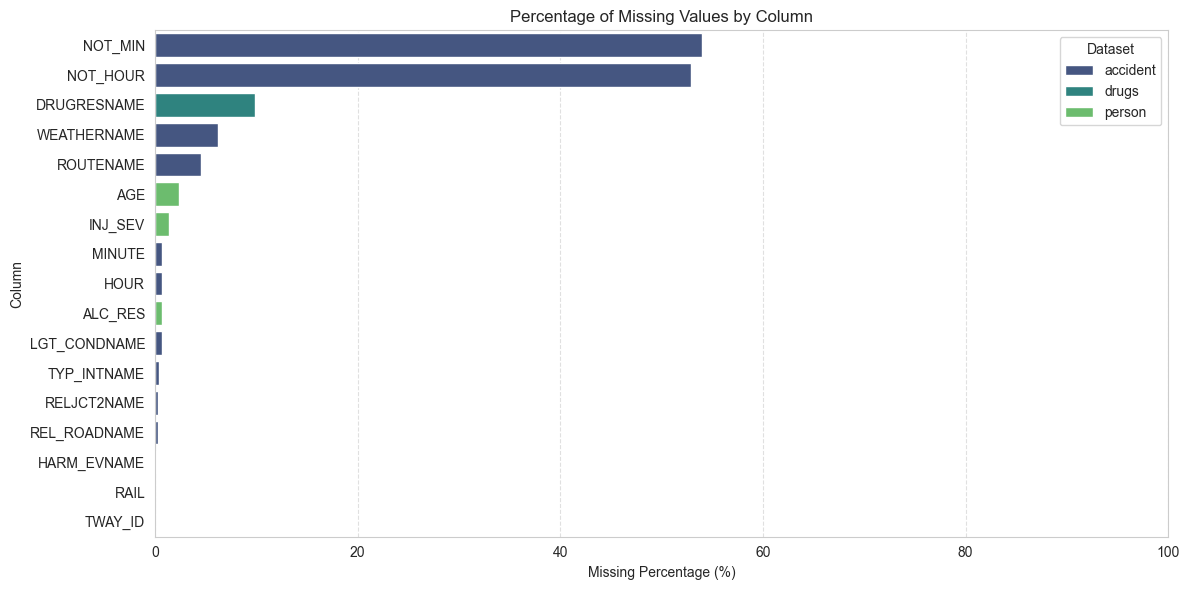


ANALYSIS FOR: ACCIDENT
Nullity Co-occurrence Score: 0.1253
-> Pattern: WEAK/MIXED


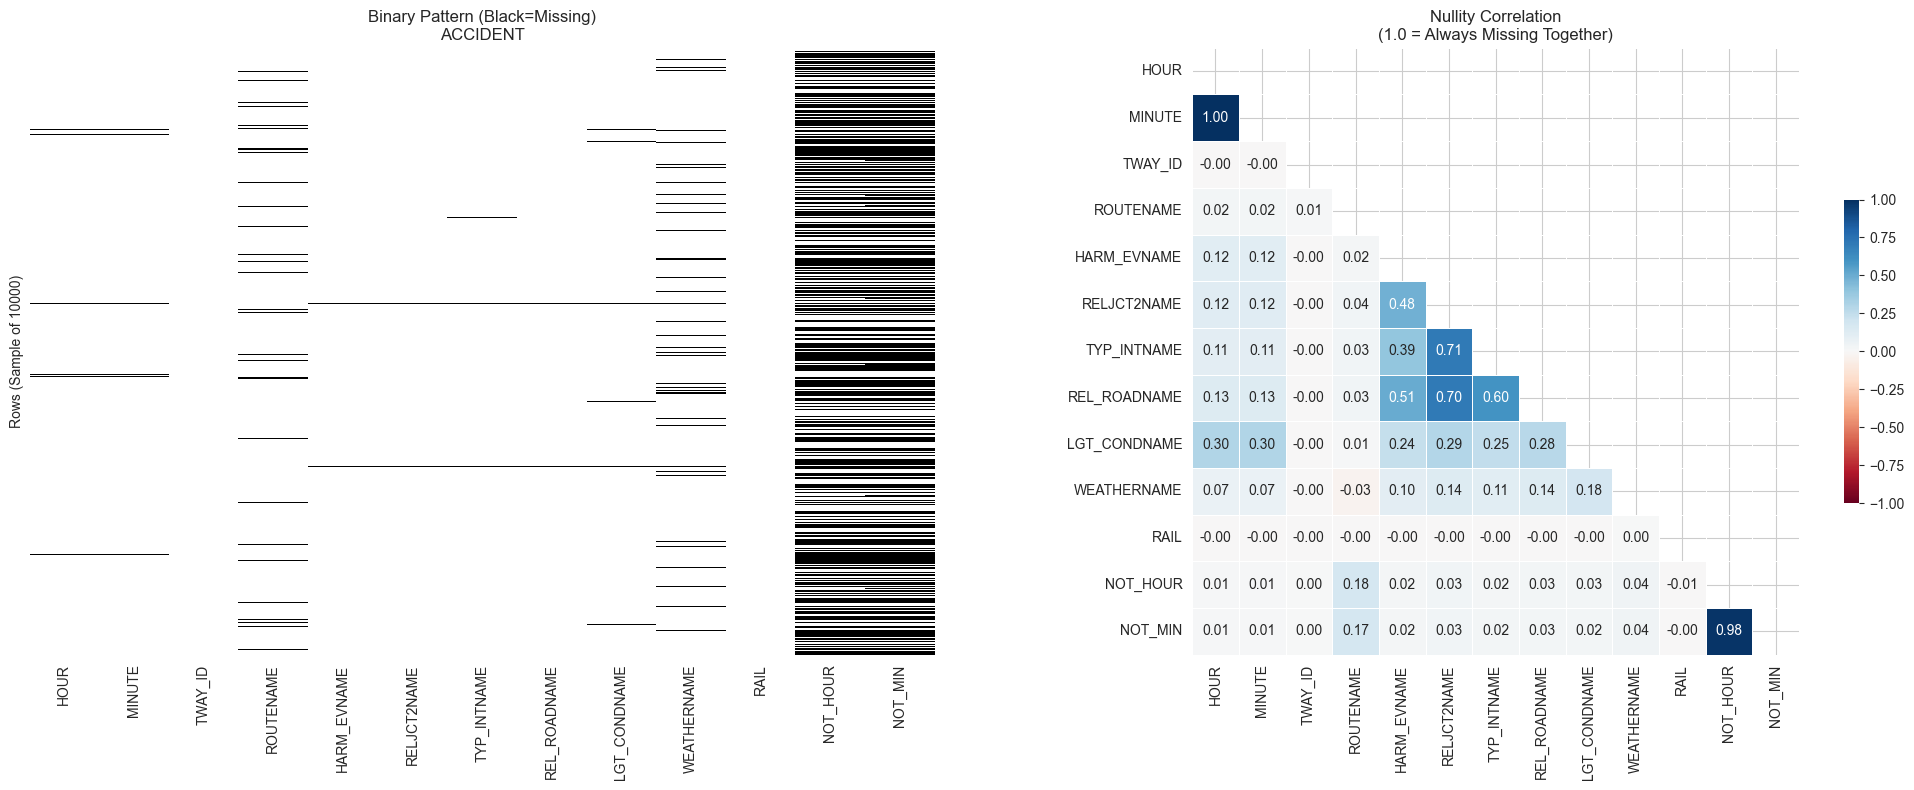


ANALYSIS FOR: PERSON
Nullity Co-occurrence Score: 0.1945
-> Pattern: WEAK/MIXED


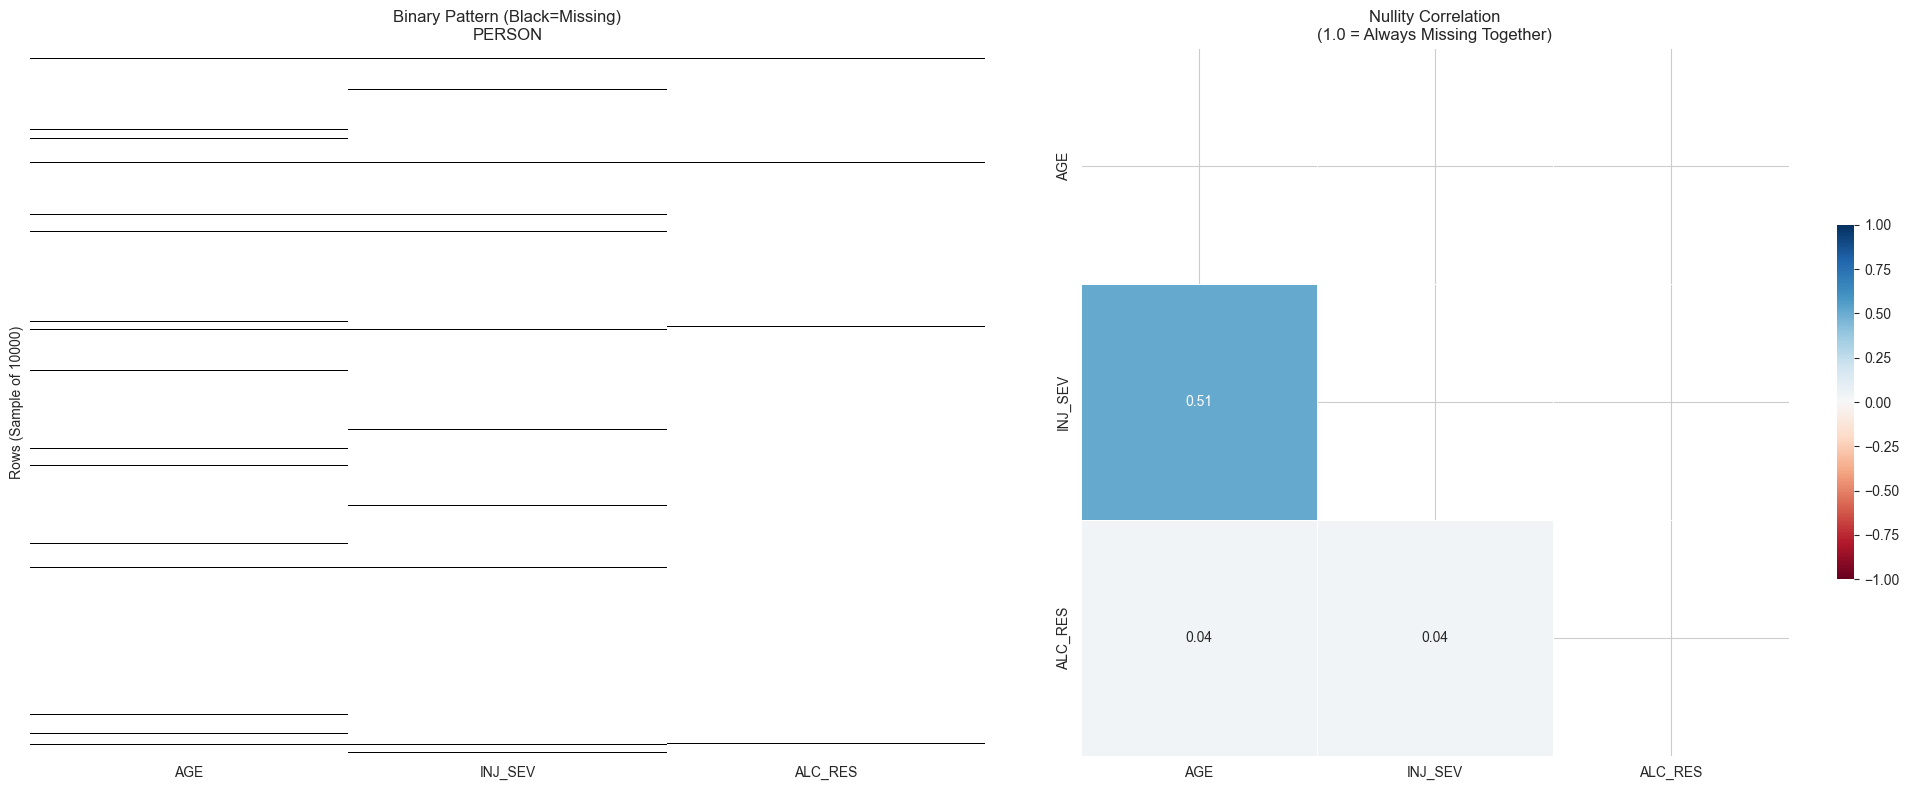

In [31]:
# --- Missing Value Analysis & Visualization ---

def calculate_nullity_score(df):
    """
    Calculates a single 'Co-occurrence Score' for a dataset.
    Returns the average correlation between missingness columns.
    """
    # Create a boolean dataframe (True where missing)
    nullity = df.isna()
    
    # Filter to columns that have *some* but not *all* missing values
    cols_varying = [col for col in df.columns if 0 < df[col].isna().sum() < len(df)]
    
    if len(cols_varying) < 2:
        return 0.0, pd.DataFrame() 
        
    # Calculate correlation matrix of the boolean dataframe
    corr_matrix = nullity[cols_varying].corr()
    
    # Calculate average correlation (excluding diagonal)
    mask = np.ones_like(corr_matrix, dtype=bool)
    np.fill_diagonal(mask, False)
    avg_score = corr_matrix.where(mask).abs().mean().mean()
    
    return avg_score, corr_matrix

def plot_missing_analysis(summary_df, data_dict):
    if summary_df.empty:
        print("No missing data to plot.")
        return

    # --- Plot 1: Percentage of Missing Values by Column ---
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=summary_df, 
        x='Missing_Percentage', 
        y='Column', 
        hue='Dataset', 
        dodge=False, 
        palette='viridis'
    )
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Missing Percentage (%)')
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

    # --- Analyze Nullity Patterns per Dataset ---
    datasets_with_missing = summary_df['Dataset'].unique()

    for name in datasets_with_missing:
        df = data_dict[name]
        
        score, corr_matrix = calculate_nullity_score(df)
        
        if corr_matrix.empty:
            continue

        print(f"\n{'='*60}")
        print(f"ANALYSIS FOR: {name.upper()}")
        print(f"Nullity Co-occurrence Score: {score:.4f}")
        if score > 0.5:
            print("-> Pattern: SYSTEMATIC (Missing values tend to occur together in the same rows)")
        elif score < 0.1:
            print("-> Pattern: RANDOM (Missing values are scattered randomly)")
        else:
            print("-> Pattern: WEAK/MIXED")
        print(f"{'='*60}")

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Plot 2: Binary Nullity Matrix
        sample_df = df[corr_matrix.columns].sample(min(len(df), 10000), random_state=42)
        sns.heatmap(sample_df.isna(), cbar=False, cmap='binary', yticklabels=False, ax=axes[0])
        axes[0].set_title(f'Binary Pattern (Black=Missing)\n{name.upper()}')
        axes[0].set_ylabel(f'Rows (Sample of {len(sample_df)})')
        
        # Plot 3: Nullity Correlation Heatmap
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(
            corr_matrix, 
            mask=mask,
            cmap='RdBu', 
            vmax=1, 
            vmin=-1, 
            center=0,
            annot=True, 
            fmt='.2f',
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            ax=axes[1]
        )
        axes[1].set_title('Nullity Correlation\n(1.0 = Always Missing Together)')
        plt.tight_layout()
        plt.show()

# Create combined dataframes for analysis (concatenating years)
combined_fars_data = {}
for data_type in SELECTED_DATA:
    dfs = []
    for year in available_years:
        if data_type in fars_data[year]:
            dfs.append(fars_data[year][data_type])
    if dfs:
        combined_fars_data[data_type] = pd.concat(dfs, ignore_index=True)

# Generate Summary DataFrame
missing_rows = []
for dataset_name, df in combined_fars_data.items():
    missing_series = df.isna().sum()
    missing_series = missing_series[missing_series > 0]
    for col, count in missing_series.items():
        total_rows = len(df)
        missing_rows.append({
            'Dataset': dataset_name,
            'Column': col,
            'Missing_Count': count,
            'Missing_Percentage': (count / total_rows) * 100
        })

missing = pd.DataFrame(missing_rows)
if not missing.empty:
    missing = missing.sort_values('Missing_Percentage', ascending=False)

# Print Stats
total_cols_checked = sum([len(df.columns) for df in combined_fars_data.values()])
print(f"Columns with missing values: {len(missing)} out of {total_cols_checked}")
print("\nColumns with missing data:")
display(missing)

# Run Visualization
plot_missing_analysis(missing, combined_fars_data)

The nullity co‑occurrence scores are low (Accident 0.125, Person 0.194), indicating a weak/mixed missingness pattern rather than a single systematic block — so most gaps appear largely random.

### 2.1. Merging Datasets across Years and Data Types

In [32]:
INTERIM_DIR = Path("data/interim")
rel_interim = rel_path(INTERIM_DIR)
INTERIM_DIR.mkdir(parents=True, exist_ok=True)

# Storage for the final merged dataframes
merged_fars = {}

print("Merging Data Across Years")

# 1. Standard Merging Loop
for data_type, columns in SELECTED_COLS.items():
    dfs_to_merge = []
    
    # Iterate through available years in chronological order
    for year in sorted(fars_data.keys()):
        # Check if this specific data type exists for this year
        if data_type in fars_data[year]:
            original_df = fars_data[year][data_type]
            
            # Filter: Keep only selected columns
            temp_df = original_df[columns].copy()
            
            # Ensure YEAR column exists for safe merging later
            if 'YEAR' not in temp_df.columns:
                temp_df['YEAR'] = year
            
            dfs_to_merge.append(temp_df)
    
    # Concatenate all years for this data type
    if dfs_to_merge:
        merged_fars[data_type] = pd.concat(dfs_to_merge, ignore_index=True)
        
        # Print summary
        num_cols = merged_fars[data_type].shape[1]
        count = len(merged_fars[data_type])
        years_present = merged_fars[data_type]['YEAR'].unique()
        print(f"- Created 'merged_fars['{data_type}']' dataframe ({num_cols} columns x {count:,} rows).")
    else:
        print(f"⚠️ No data found to merge for {data_type}")


Merging Data Across Years
- Created 'merged_fars['accident']' dataframe (36 columns x 105,060 rows).
- Created 'merged_fars['drugs']' dataframe (4 columns x 327,625 rows).
- Created 'merged_fars['person']' dataframe (8 columns x 259,587 rows).


#### 2.1.1. Understand the age distribution

We will analyze the age distribution of individuals involved in fatal accidents to identify patterns or trends that may be relevant to our study.

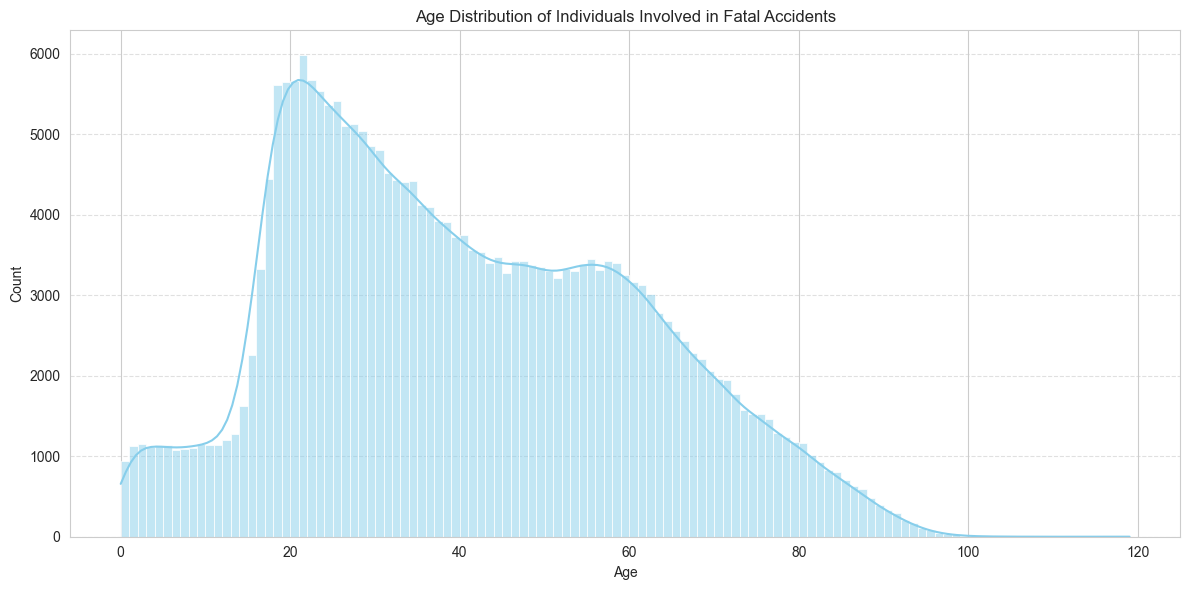

Number of people with age above 120: 0


In [33]:
persons = merged_fars['person']

#plot age distribution
plt.figure(figsize=(12, 6))
sns.histplot(persons['AGE'].dropna(), bins=range(0, 100, 1), kde=True, color='skyblue')
plt.title('Age Distribution of Individuals Involved in Fatal Accidents')
plt.xlabel('Age')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("Number of people with age above 120:", persons[persons['AGE'] > 120].shape[0])

Instead of relying on arbitrary age bins, the following steps were taken to create meaningful age features:

* **Optimal Cluster Determination:** The **Gaussian Mixture Model (GMM)** is applied to the non-missing `AGE` data, and the optimal number of clusters is determined using the **Bayesian Information Criterion (BIC)** score.
* **Age Group Features:** For the optimal number of clusters ($N$), $N$ binary features are created (e.g., `AGE_GROUP_0_to_12`), indicating the demographic cluster a crash is associated with.


### 2.2. Merging Age Group Features into joined Dataset


--- Calculating Derived Columns: TOTAL_HARM, INTOXICATION TARGETS, & AGE GROUPS ---

  > Performing GMM Age Clustering...
    - Optimal Age Groups: 7 (BIC: 2214118)

  > GMM Age Group Summary:


,Group,Age Range,Mean Age,Std Dev,Count,Proportion (%)
0,0,0-11,5.6,3.43,"13,324",5.1%
1,1,12-29,21.9,4.41,"79,138",30.5%
2,2,30-42,35.7,3.73,"53,196",20.5%
3,3,43-54,48.5,3.46,"40,258",15.5%
4,4,55-65,59.7,3.11,"34,160",13.2%
5,5,66-77,70.8,3.41,"22,044",8.5%
6,6,78-119,83.6,4.58,"11,312",4.4%



  > Intoxication Target Distribution (Accident Level) only for Drivers with Intoxication Data:
    - DRUNK_DRIVER:
      0 (No ):  79,997 ( 76.1%)
      1 (Yes):  25,063 ( 23.9%)
    - DRUGGED_DRIVER:
      0 (No ):  70,011 ( 66.6%)
      1 (Yes):  35,049 ( 33.4%)
    - DRUG_&_ALC:
      0 (No ):  93,985 ( 89.5%)
      1 (Yes):  11,075 ( 10.5%)
    - DRUG_OR_ALC:
      0 (No ):  56,023 ( 53.3%)
      1 (Yes):  49,037 ( 46.7%)

Successfully added 'TOTAL_HARM', 4 Intoxication Targets (DRUNK_DRIVER, DRUGGED_DRIVER, DRUG_&_ALC, DRUG_OR_ALC)
 for drivers only, and 7 Age Groups.


,ST_CASE,YEAR,TOTAL_HARM,DRUNK_DRIVER,DRUGGED_DRIVER,DRUG_&_ALC,DRUG_OR_ALC,AGE_GROUP_0_to_11,AGE_GROUP_12_to_29,AGE_GROUP_30_to_42,AGE_GROUP_43_to_54,AGE_GROUP_55_to_65,AGE_GROUP_66_to_77,AGE_GROUP_78_to_119
0,10001,2018,4,0,0,0,0,0,0,0,0,1,0,0
1,10002,2018,8,0,0,0,0,0,2,0,0,0,0,0
2,10003,2018,6,0,1,0,1,0,0,2,0,0,0,0
3,10004,2018,4,0,0,0,0,0,1,0,0,1,0,0
4,10005,2018,6,0,0,0,0,0,1,0,1,0,0,0


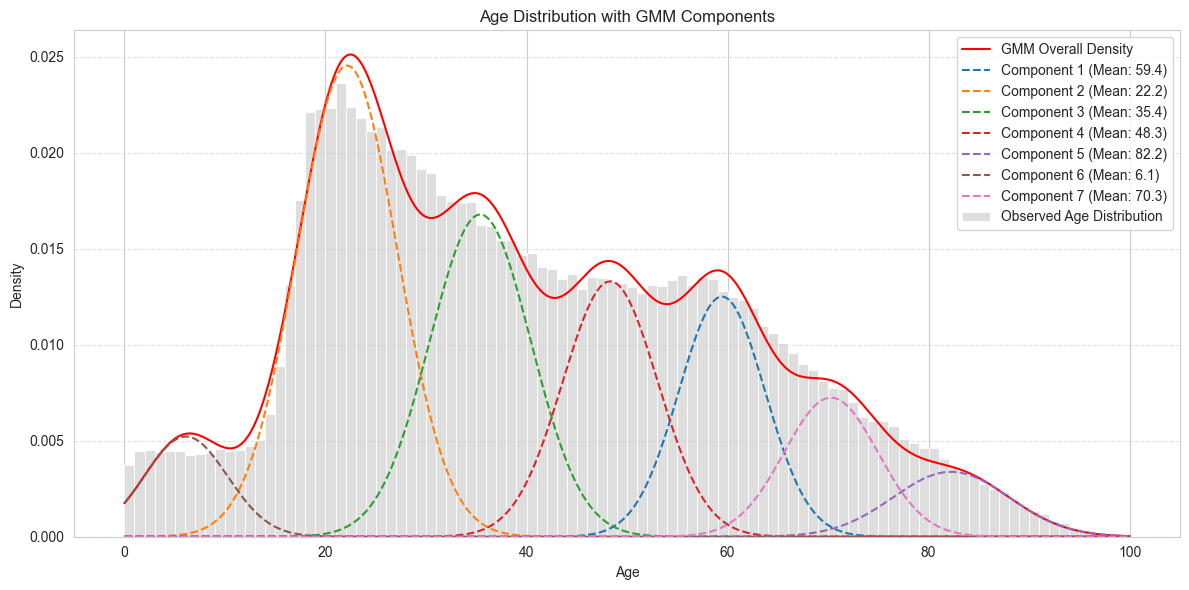

In [34]:
# 2. Calculate New Columns (Vectorized Approach)
# We apply this logic only if we have the necessary datasets
if all(k in merged_fars for k in ['accident', 'person', 'drugs']):
    print("\n--- Calculating Derived Columns: TOTAL_HARM, INTOXICATION TARGETS, & AGE GROUPS ---\n")
    
    joined_data = merged_fars['accident'].copy()
    per_df = merged_fars['person'].copy()
    drg_df = merged_fars['drugs'].copy()
    
    # Define keys for joining
    join_keys = ['ST_CASE', 'YEAR']
    
    # ==============================================================================
    # 1. AGE GROUP CLUSTERING (GMM)
    # ==============================================================================
    print("  > Performing GMM Age Clustering...")
    
    # Ensure AGE is numeric
    per_df['AGE'] = pd.to_numeric(per_df['AGE'], errors='coerce')
    
    # Extract non-null ages for fitting
    age_non_null = per_df['AGE'].dropna().values.reshape(-1, 1)
    
    # Find optimal clusters (BIC)
    bic_max_components = 7 # Max number of clusters to try
    best_bic = np.inf
    best_n = 2
    best_gmm = None
    
    for n in range(2, bic_max_components + 1):
        gmm_temp = GaussianMixture(n_components=n, random_state=42)
        gmm_temp.fit(age_non_null)
        bic = gmm_temp.bic(age_non_null)
        if bic < best_bic:
            best_bic = bic
            best_n = n
            best_gmm = gmm_temp
            
    print(f"    - Optimal Age Groups: {best_n} (BIC: {best_bic:.0f})")
    
    # Predict clusters for all persons (handling NaNs)
    # We only predict for rows where AGE is not null
    valid_age_mask = per_df['AGE'].notna()
    per_df.loc[valid_age_mask, 'AGE_CLUSTER_LABEL'] = best_gmm.predict(per_df.loc[valid_age_mask, 'AGE'].values.reshape(-1, 1))
    
    # Sort clusters by mean age to make them intuitive (0=Youngest, N=Oldest)
    cluster_means = per_df.groupby('AGE_CLUSTER_LABEL')['AGE'].mean().sort_values()
    remap_dict = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index)}
    per_df['AGE_GROUP_SORTED'] = per_df['AGE_CLUSTER_LABEL'].map(remap_dict)
    
    # Create Binary Columns for each Group
    age_group_cols = []
    gmm_summary_data = []
    
    # Get GMM parameters for summary (mapped to sorted indices)
    # Note: best_gmm.means_ are not sorted by value, so we need to map them 
    # carefully if we want exact model params.
    # However, for the report, the empirical min/max/mean from the data assigned 
    # to that cluster is often more descriptive.
    
    for i in range(best_n):
        # Determine bounds for naming
        subset = per_df[per_df['AGE_GROUP_SORTED'] == i]
        
        if not subset.empty:
            min_age = int(subset['AGE'].min())
            max_age = int(subset['AGE'].max())
            mean_age = subset['AGE'].mean()
            std_age = subset['AGE'].std()
            count = len(subset)
            prop = count / len(per_df) * 100
            
            col_name = f"AGE_GROUP_{min_age}_to_{max_age}"
            
            gmm_summary_data.append({
                'Group': i,
                'Age Range': f"{min_age}-{max_age}",
                'Mean Age': mean_age,
                'Std Dev': std_age,
                'Count': count,
                'Proportion (%)': prop
            })
        else:
            col_name = f"AGE_GROUP_{i}_EMPTY"
            gmm_summary_data.append({
                'Group': i,
                'Age Range': "Empty",
                'Mean Age': np.nan,
                'Std Dev': np.nan,
                'Count': 0,
                'Proportion (%)': 0.0
            })
            
        # Create binary flag: 1 if person belongs to this group, 0 otherwise
        per_df[col_name] = (per_df['AGE_GROUP_SORTED'] == i).astype(int)
        age_group_cols.append(col_name)

    # Display Summary DataFrame
    gmm_summary_df = pd.DataFrame(gmm_summary_data)
    print("\n  > GMM Age Group Summary:")
    display(gmm_summary_df.style.format({
        'Mean Age': '{:.1f}',
        'Std Dev': '{:.2f}',
        'Count': '{:,}',
        'Proportion (%)': '{:.1f}%'
    }))

    # Aggregate Age Groups per Accident (Sum of people in that age group per crash)
    age_agg = per_df.groupby(join_keys)[age_group_cols].sum().reset_index()


    # ==============================================================================
    # 2. TOTAL_HARM CALCULATION
    # ==============================================================================
    # Logic: Sum of INJ_SEV <= 4. If INJ_SEV == 5 (Unknown Inj), add 1.
    
    per_df['INJ_SEV'] = pd.to_numeric(per_df['INJ_SEV'], errors='coerce').fillna(0)
    
    per_df['calc_harm'] = 0
    mask_sev = per_df['INJ_SEV'] <= 4
    mask_unk = per_df['INJ_SEV'] == 5
    
    per_df.loc[mask_sev, 'calc_harm'] = per_df.loc[mask_sev, 'INJ_SEV']
    per_df.loc[mask_unk, 'calc_harm'] = 1
    
    harm_series = per_df.groupby(join_keys)['calc_harm'].sum().rename('TOTAL_HARM')
    

    # 3. INTOXICATION TARGETS CALCULATION (drivers only)
    # ==============================================================================
    # Targets: DRUNK_DRIVER, DRUGGED_DRIVER, DRUG_&_ALC, DRUG_OR_ALC
    
    # Identify Drivers
    drivers = per_df[per_df['PER_TYP'] == 1].copy()
    
    # --- A. Alcohol (DRUNK_DRIVER) ---
    # Logic: Driver with ALC_RES >= 80 (0.08%) OR DRINKING=1 (Police Reported)
    drivers['DRUNK_DRIVER'] = pd.to_numeric(drivers['ALC_RES'], errors='coerce').fillna(0)
    
    drivers['DRINKING'] = pd.to_numeric(drivers['DRINKING'], errors='coerce').fillna(0)
    mask_drinking_reported = (drivers['DRINKING'] == 1)
 

    # BAC >= 80 and not special unknown codes (995+)
    # Note: 0.080% is the legal limit. FARS often records this as 80.
    mask_bac_high = (drivers['DRUNK_DRIVER'] >= 80) & (drivers['DRUNK_DRIVER'] < 995)
    
    mask_drunk = mask_bac_high | mask_drinking_reported
    
    alc_cases = drivers.loc[mask_drunk, join_keys].drop_duplicates()
    alc_cases['DRUNK_DRIVER'] = 1
    
    # --- B. Drugs (DRUGGED_DRIVER) ---
    # Logic: Driver with positive drug test result (excluding certain results)
    excluded_results = [
        None, 
        'Test Not Given', 
        'None Detected/Below Threshold',
        'Tested, No Drugs Found/Negative', 
        'Anabolic Steroids'
    ]
    
    positive_drugs = drg_df[
        drg_df['DRUGRESNAME'].notna() & 
        (~drg_df['DRUGRESNAME'].isin(excluded_results))
    ].copy()
    
    drugged_drivers = pd.merge(
        drivers[join_keys + ['PER_NO']], 
        positive_drugs, 
        on=join_keys + ['PER_NO'], 
        how='inner'
    )
    drug_cases = drugged_drivers[join_keys].drop_duplicates()
    drug_cases['DRUGGED_DRIVER'] = 1
    
    # --- C. Merge Targets ---
    # We merge these into a temporary targets dataframe
    targets_df = pd.merge(alc_cases, drug_cases, on=join_keys, how='outer')

    targets_df['DRUNK_DRIVER'] = targets_df['DRUNK_DRIVER'].fillna(0).astype(int)
    targets_df['DRUGGED_DRIVER'] = targets_df['DRUGGED_DRIVER'].fillna(0).astype(int)
    
    # --- D. Calculate Combinations ---
    targets_df['DRUG_&_ALC'] = (targets_df['DRUNK_DRIVER'] & targets_df['DRUGGED_DRIVER']).astype(int)
    targets_df['DRUG_OR_ALC'] = (targets_df['DRUNK_DRIVER'] | targets_df['DRUGGED_DRIVER']).astype(int)
    
    # ==============================================================================
    # 4. MERGE EVERYTHING BACK TO ACCIDENT DATA
    # ==============================================================================
    joined_data = pd.merge(joined_data, harm_series, on=join_keys, how='left')
    joined_data = pd.merge(joined_data, targets_df, on=join_keys, how='left') # Merge Targets
    joined_data = pd.merge(joined_data, age_agg, on=join_keys, how='left') # Merge Age Groups
    
    # Fill Target NaNs with 0 (implies no intoxication found)
    target_cols = ['DRUNK_DRIVER', 'DRUGGED_DRIVER', 'DRUG_&_ALC', 'DRUG_OR_ALC']
    joined_data[target_cols] = joined_data[target_cols].fillna(0).astype(int)
    
    # Fill Age Group NaNs with 0 (implies no persons of that age in that crash)
    joined_data[age_group_cols] = joined_data[age_group_cols].fillna(0).astype(int)

    # Print Distribution of Targets
    print("\n  > Intoxication Target Distribution (Accident Level) only for Drivers with Intoxication Data:")
    for col in target_cols:
        counts = joined_data[col].value_counts().sort_index()
        total = len(joined_data)
        print(f"    - {col}:")
        for val, count in counts.items():
            pct = (count / total) * 100
            label = "Yes" if val == 1 else "No "
            print(f"      {val} ({label}): {count:>7,} ({pct:>5.1f}%)")
    
    # Save the updated accident file
    file_path = INTERIM_DIR / "FARS_merged.csv"
    joined_data.to_csv(file_path, index=False)
    
    print(f"\nSuccessfully added 'TOTAL_HARM', {len(target_cols)} Intoxication Targets ({', '.join(target_cols)})\n for drivers only, and {len(age_group_cols)} Age Groups.")

    # Display columns to verify
    cols_to_show = ['ST_CASE', 'YEAR', 'TOTAL_HARM'] + target_cols + age_group_cols
    display(joined_data[cols_to_show].head())
    
    def plot_age_distribution_with_gmm(age_data, gmm_model):
        """
        Plots the age distribution with GMM components overlaid.
        """
        plt.figure(figsize=(12, 6))
        
        # Plot histogram of ages
        sns.histplot(age_data, bins=range(0, 100, 1), kde=False, color='lightgray', stat='density', label='Observed Age Distribution')
        
        # Generate age range for GMM plotting
        x = np.linspace(0, 100, 1000).reshape(-1, 1)
        
        # Calculate GMM PDF
        logprob = gmm_model.score_samples(x)
        pdf = np.exp(logprob)
        
        # Plot GMM overall density
        plt.plot(x, pdf, '-r', label='GMM Overall Density')
        
        # Plot individual GMM components
        for i in range(gmm_model.n_components):
            mean = gmm_model.means_[i][0]
            variance = gmm_model.covariances_[i][0][0]
            weight = gmm_model.weights_[i]
            component_pdf = weight * norm.pdf(x, mean, np.sqrt(variance))
            plt.plot(x, component_pdf, '--', label=f'Component {i+1} (Mean: {mean:.1f})')
        
        plt.title('Age Distribution with GMM Components')
        plt.xlabel('Age')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # Plot the age distribution with GMM components
    plot_age_distribution_with_gmm(per_df['AGE'].dropna(), best_gmm)

In [ ]:
# --- Result Access ---
# You now have:
# display(merged_fars['accident'].head(2))
# display(merged_fars['person'].head(2))
# merged_fars['drugs']


---

## 3. Exploratory Data Analysis (EDA)

### 3.1. Geographic Coverage

In [35]:
# State distribution
state_counts = joined_data['STATENAME'].value_counts().head(15)
print("Top 15 States by fatal accident Count:")
print("=" * 40)
for state, count in state_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"{state:15s} {count:>10,}  ({pct:5.2f}%)")

Top 15 States by fatal accident Count:
California          10,639  (10.13%)
Texas               10,481  ( 9.98%)
Florida              9,052  ( 8.62%)
Georgia              4,277  ( 4.07%)
North Carolina       4,128  ( 3.93%)
Tennessee            3,233  ( 3.08%)
Pennsylvania         3,226  ( 3.07%)
Ohio                 3,185  ( 3.03%)
Illinois             3,032  ( 2.89%)
Arizona              3,021  ( 2.88%)
South Carolina       2,872  ( 2.73%)
Michigan             2,830  ( 2.69%)
New York             2,822  ( 2.69%)
Alabama              2,625  ( 2.50%)
Missouri             2,572  ( 2.45%)


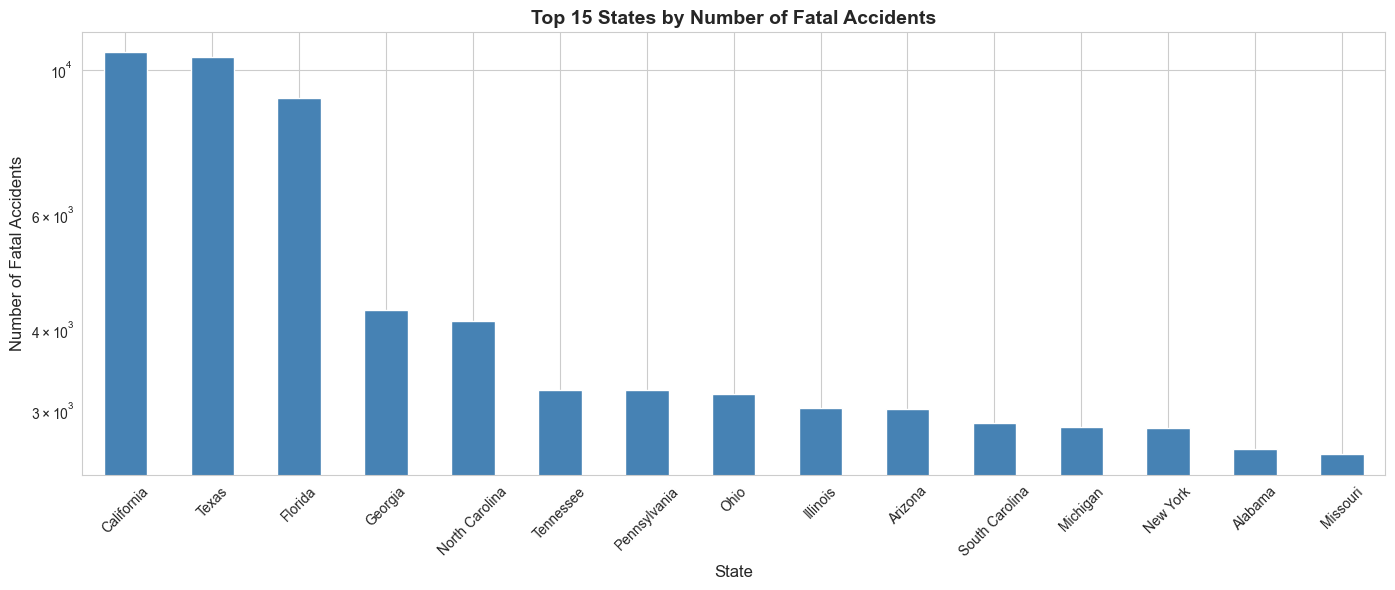

In [36]:
# Visualize state distribution
fig, ax = plt.subplots(figsize=(14, 6))
state_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Top 15 States by Number of Fatal Accidents', fontsize=14, fontweight='bold')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{float(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale('log')
plt.show()


### 3.2. Temporal Patterns

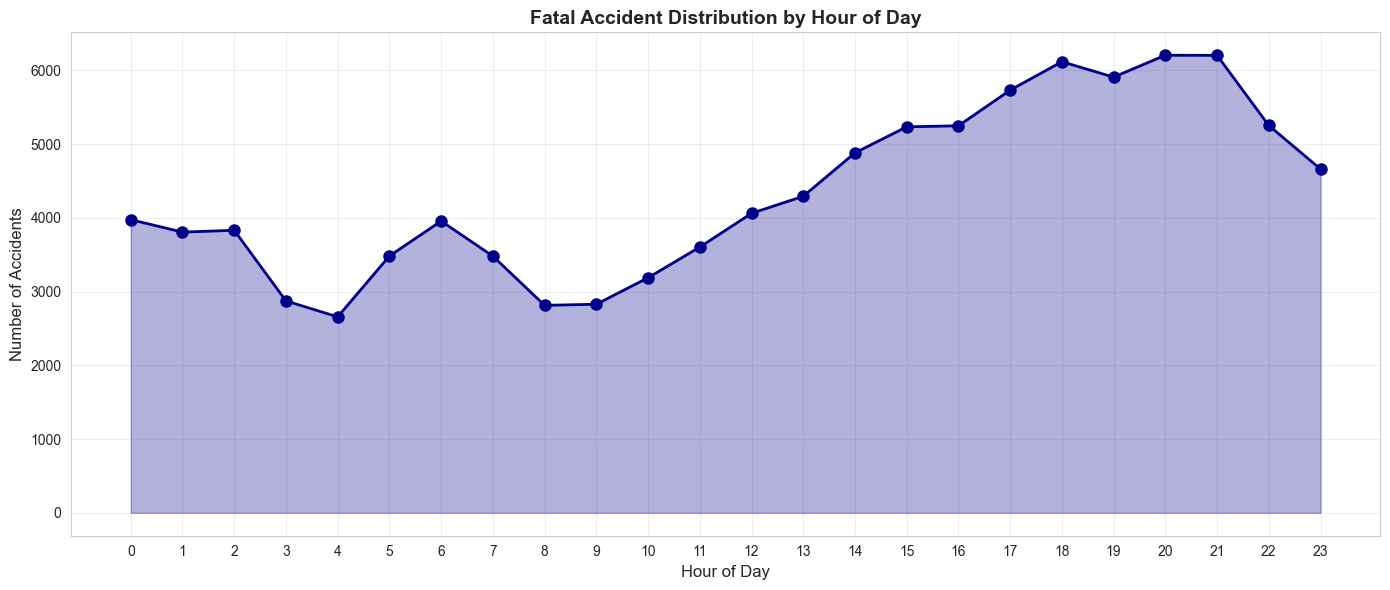

In [43]:
# Visualize accident distribution by hour of day
hour_counts = joined_data['HOUR'].value_counts().sort_index()

x_values = hour_counts.index.astype(int)
y_values = hour_counts.astype(int)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(x_values, y_values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(x_values, y_values, alpha=0.3, color='darkblue')
ax.set_title('Fatal Accident Distribution by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

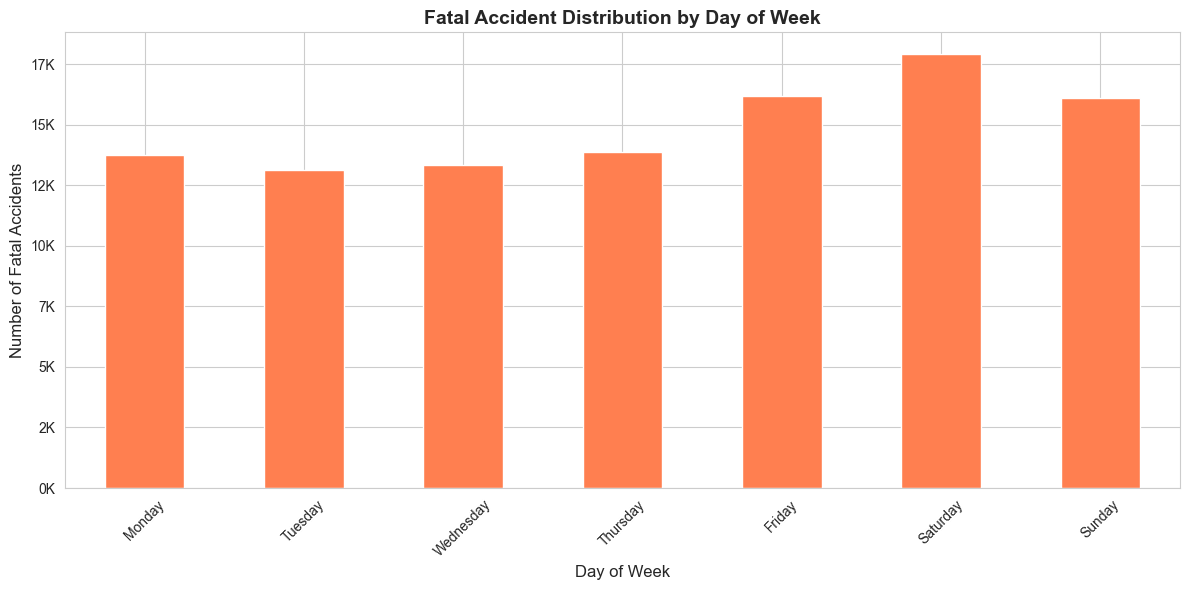

In [44]:
# Accidents by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = joined_data['DAY_WEEKNAME'].value_counts().reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 6))
day_counts.plot(kind='bar', ax=ax, color='coral')
ax.set_title('Fatal Accident Distribution by Day of Week', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Fatal Accidents', fontsize=12)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observation:** The weekend has a higher number of fatal accidents compared to working days, let's dive into the hourly distribution on weekends to see why

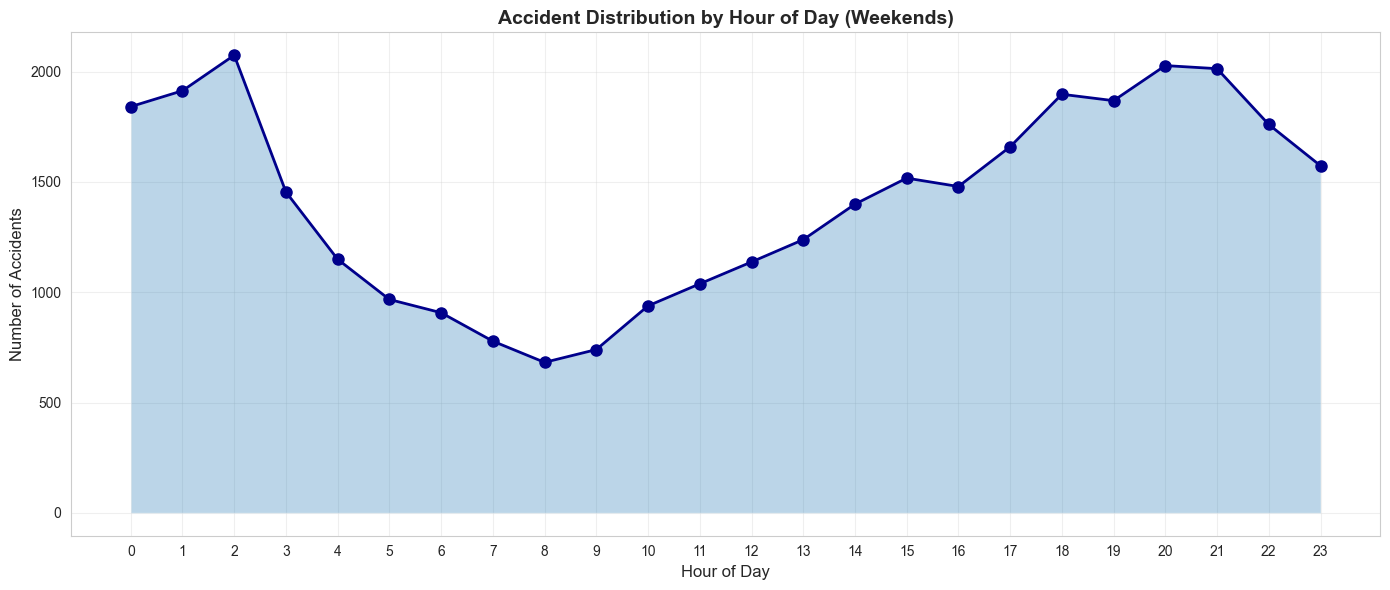


Top 10 Peak Hours for Accidents:

At 02h: 2,074 accidents (3.04x minimum)
At 20h: 2,027 accidents (2.97x minimum)
At 21h: 2,013 accidents (2.95x minimum)
At 01h: 1,913 accidents (2.80x minimum)
At 18h: 1,897 accidents (2.78x minimum)
At 19h: 1,868 accidents (2.74x minimum)
At 00h: 1,841 accidents (2.70x minimum)
At 22h: 1,760 accidents (2.58x minimum)
At 17h: 1,659 accidents (2.43x minimum)
At 23h: 1,573 accidents (2.31x minimum)

Minimum Accidents in a Single Hour (weekends): 682 accidents


In [46]:
# Accidents by hour of day on weekends
hour_counts = joined_data[joined_data['DAY_WEEKNAME'].isin(['Saturday', 'Sunday'])]['HOUR'].value_counts().sort_index()
hour_counts = hour_counts.astype(int)
hour_counts.index = hour_counts.index.astype(int)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(hour_counts.index, hour_counts.values, marker='o', linewidth=2, markersize=8, color='darkblue')
ax.fill_between(hour_counts.index, hour_counts.values, alpha=0.3)
ax.set_title('Accident Distribution by Hour of Day (Weekends)', fontsize=14, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Accidents', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

# Identify the peak hours for accidents

min_accidents = hour_counts.min()
peak_hours = hour_counts.sort_values(ascending=False).head(10)

print("\nTop 10 Peak Hours for Accidents:\n")
for hour, count in peak_hours.items():
    print(f"At {int(hour):02d}h: {count:,} accidents ({count/min_accidents:.2f}x minimum)")  

print(f"\nMinimum Accidents in a Single Hour (weekends): {min_accidents:,} accidents")

**Observation:** The rush hour patterns are less pronounced on weekends compared to weekdays. While there are still peaks in accident counts during late morning and early afternoon hours, the overall distribution is more uniform throughout the day. This suggests that weekend traffic is less influenced by traditional work commute times, leading to a more even spread of accidents across different hours.

### 3.3. Impairment and Severity Distribution

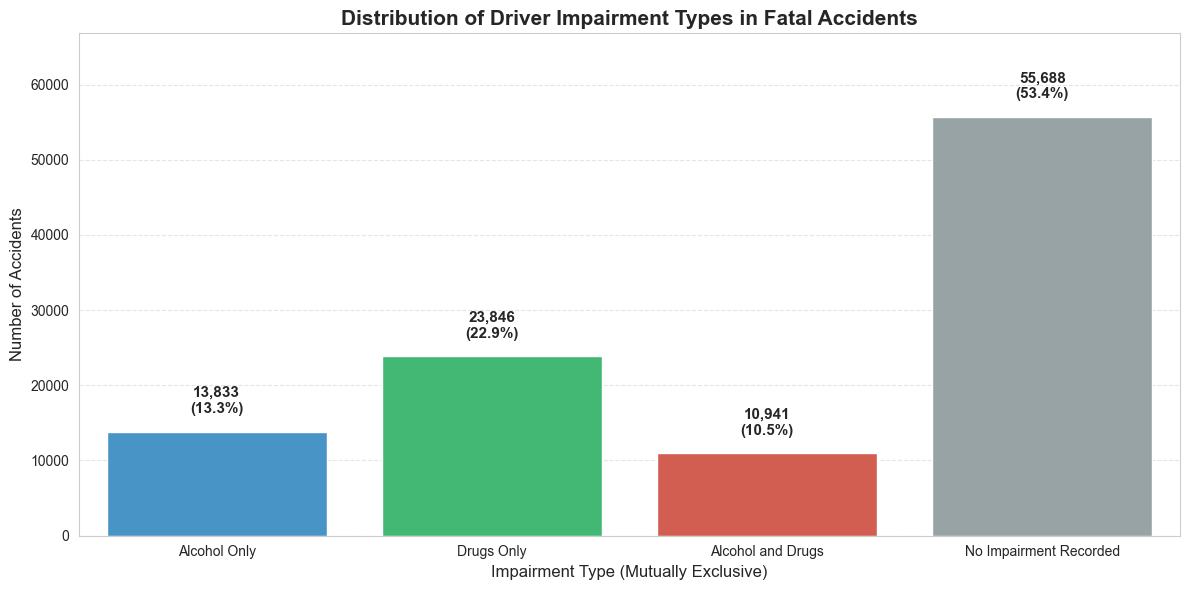

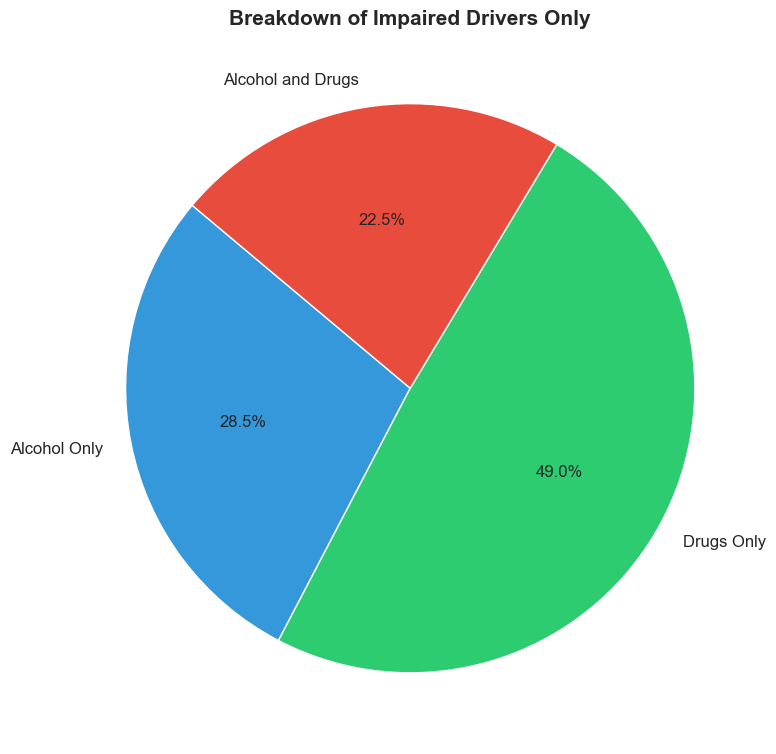

In [52]:

impairment_counts = {
    'Alcohol Only': ((joined_data['DRUNK_DRIVER'] == 1) & (joined_data['DRUGGED_DRIVER'] == 0)).sum(),
    'Drugs Only': ((joined_data['DRUGGED_DRIVER'] == 1) & (joined_data['DRUNK_DRIVER'] == 0)).sum(),
    'Alcohol and Drugs': (joined_data['DRUG_&_ALC'] == 1).sum(),
    'No Impairment Recorded': ((joined_data['DRUNK_DRIVER'] == 0) & (joined_data['DRUGGED_DRIVER'] == 0)).sum()
}

imp_df = pd.DataFrame(list(impairment_counts.items()), columns=['Category', 'Count'])
total_accidents = imp_df['Count'].sum()
imp_df['Percentage'] = (imp_df['Count'] / total_accidents) * 100

plt.figure(figsize=(12, 6))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#95a5a6']

ax = sns.barplot(x='Category', y='Count', data=imp_df, palette=colors, hue='Category', dodge=False)

plt.title('Distribution of Driver Impairment Types in Fatal Accidents', fontsize=15, fontweight='bold')
plt.ylabel('Number of Accidents', fontsize=12)
plt.xlabel('Impairment Type (Mutually Exclusive)', fontsize=12)

# Add percentage and count annotations
for i, p in enumerate(ax.patches):
    height = p.get_height()
    count = int(height)
    pct = imp_df.loc[i, 'Percentage']
    
    ax.text(p.get_x() + p.get_width()/2., height + (total_accidents*0.02),
            f'{count:,}\n({pct:.1f}%)',
            ha="center", va='bottom', fontsize=11, fontweight='bold')
            
plt.ylim(0, imp_df['Count'].max() * 1.2) # Add headroom for labels
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Only Impaired Drivers (Pie Chart)
impaired_subset = imp_df[imp_df['Category'] != 'No Impairment Recorded'].copy()

if not impaired_subset.empty:
    plt.figure(figsize=(8, 8))
    
    # Pie Chart
    plt.pie(impaired_subset['Count'], labels=impaired_subset['Category'], 
            autopct='%1.1f%%', startangle=140, colors=['#3498db', '#2ecc71', '#e74c3c'],
            textprops={'fontsize': 12})
    
    plt.title('Breakdown of Impaired Drivers Only', fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [53]:
# Severity distribution
severity_counts = joined_data['TOTAL_HARM'].value_counts().sort_index()

print("Accident Severity Distribution:")
print("=" * 50)
print("Level  | Count    | Percentage")
print("-" * 50)
for sev, count in severity_counts.items():
    pct = (count / len(joined_data)) * 100
    print(f"  {sev:<4} | {count:>8,} | {pct:>6.2f}%")

print("\nNote: Severity levels 4+, sum of all casualties in each fatal accident (1 = Possible injury, 2 = Suspected minor injury, 3 = Suspected serious injury, 4 = fatality)")

Accident Severity Distribution:
Level  | Count    | Percentage
--------------------------------------------------
  4    |   60,271 |  57.78%
  5    |    5,956 |   5.71%
  6    |    9,334 |   8.95%
  7    |    8,946 |   8.58%
  8    |    5,757 |   5.52%
  9    |    2,640 |   2.53%
  10   |    3,397 |   3.26%
  11   |    1,833 |   1.76%
  12   |    1,559 |   1.49%
  13   |    1,156 |   1.11%
  14   |      867 |   0.83%
  15   |      525 |   0.50%
  16   |      539 |   0.52%
  17   |      333 |   0.32%
  18   |      259 |   0.25%
  19   |      246 |   0.24%
  20   |      156 |   0.15%
  21   |      118 |   0.11%
  22   |       98 |   0.09%
  23   |       62 |   0.06%
  24   |       42 |   0.04%
  25   |       28 |   0.03%
  26   |       28 |   0.03%
  27   |       17 |   0.02%
  28   |       17 |   0.02%
  29   |       18 |   0.02%
  30   |       20 |   0.02%
  31   |       15 |   0.01%
  32   |        8 |   0.01%
  33   |        6 |   0.01%
  34   |        8 |   0.01%
  35   |        6 

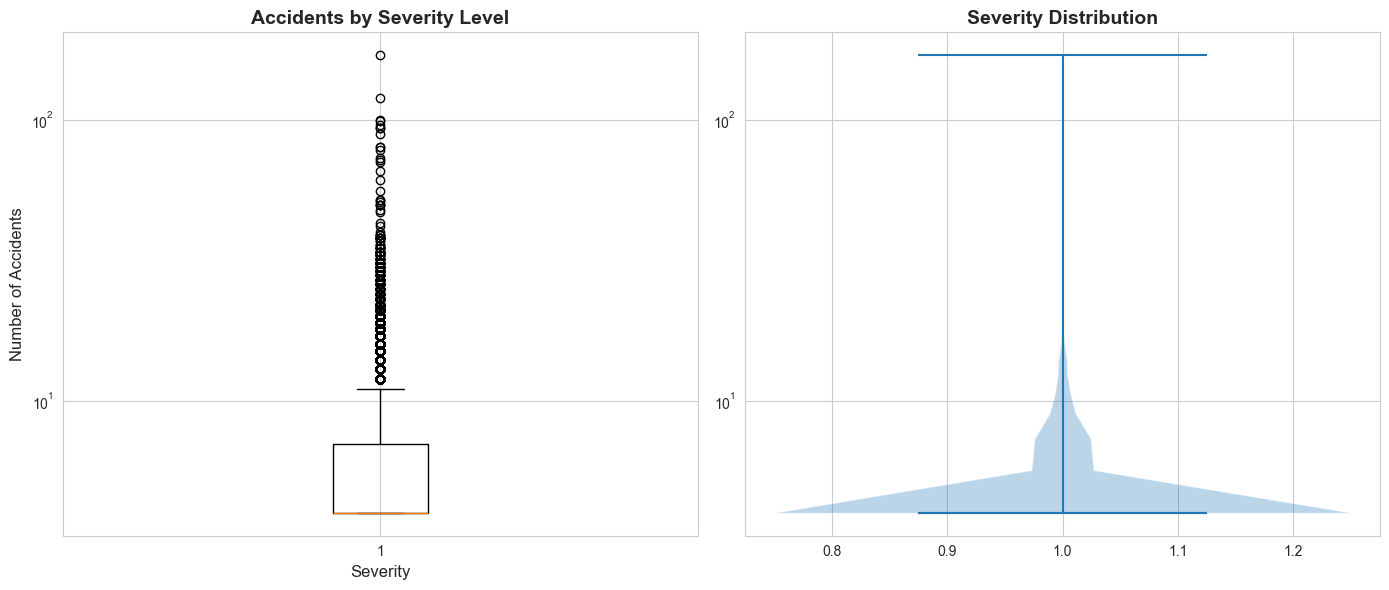

In [54]:
# Visualize severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
ax1.boxplot(joined_data['TOTAL_HARM'])
ax1.set_title('Accidents by Severity Level', fontsize=14, fontweight='bold')
ax1.semilogy()
ax1.set_xlabel('Severity', fontsize=12)
ax1.set_ylabel('Number of Accidents', fontsize=12)

# Violin plot
ax2.violinplot(joined_data['TOTAL_HARM'].astype(float), showmeans=False, showmedians=True)
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.semilogy()

plt.tight_layout()
plt.show()

### 3.4. Weather Conditions

In [55]:
# Top weather conditions
weather_counts = joined_data['WEATHERNAME'].value_counts().head(15)

print("Top 15 Weather Conditions:")
print("=" * 60)
for i, (weather, count) in enumerate(weather_counts.items(), 1):
    pct = (count / len(joined_data)) * 100
    print(f"{i:2d}. {weather:35s} {count:>8,}  ({pct:5.2f}%)")

Top 15 Weather Conditions:
 1. Clear                                 72,732  (69.73%)
 2. Cloudy                                14,579  (13.98%)
 3. Rain                                   7,968  ( 7.64%)
 4. Fog, Smog, Smoke                       1,111  ( 1.07%)
 5. Snow                                     936  ( 0.90%)
 6. Sleet or Hail                            156  ( 0.15%)
 7. Severe Crosswinds                        146  ( 0.14%)
 8. Other                                    103  ( 0.10%)
 9. Blowing Snow                              93  ( 0.09%)
10. Freezing Rain or Drizzle                  78  ( 0.07%)
11. Blowing Sand, Soil, Dirt                  28  ( 0.03%)


### 3.5. Key Findings Summary

In [56]:
print("="*80)
print("KEY FINDINGS - FARS DATASET (2023)")
print("="*80)

print("\nDATASET SIZE:")
print(f"   • Total records: {len(joined_data):,} accidents")
print(f"   • Features: {len(joined_data.columns)}")
print(f"   • Memory usage: {joined_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nTEMPORAL COVERAGE:")
print(f"   • Years covered: {joined_data['YEAR'].unique().tolist()}")

print("\nGEOGRAPHIC COVERAGE:")
print(f"   • States: {joined_data['STATENAME'].nunique()}")
print(f"   • Top state: {joined_data['STATENAME'].value_counts().index[0]} ({joined_data['STATENAME'].value_counts().iloc[0]:,} accidents)")

print("\nWEATHER CONDITIONS:")
print(f"   • Most common: {joined_data['WEATHERNAME'].value_counts().index[0]}")

print("\nDEMOGRAPHICS:")
# Identify the most common age group from the binary columns created earlier
age_cols = [c for c in joined_data.columns if c.startswith('AGE_GROUP_')]
if age_cols:
    top_age_col = joined_data[age_cols].sum().idxmax()
    count = joined_data[top_age_col].sum()
    # Clean up label (e.g., "AGE_GROUP_25_to_34" -> "25-34")
    label = top_age_col.replace('AGE_GROUP_', '').replace('_to_', '-')
    print(f"   • Most common age group: {label} ({count:,} accidents, {count/len(joined_data)*100:.1f}%)")

print("\nIMPAIRMENT TYPES:")
print(f"   • Alcohol involved: {joined_data['DRUNK_DRIVER'].mean()*100:.1f}%")
print(f"   • Drugs involved: {joined_data['DRUGGED_DRIVER'].mean()*100:.1f}%")
print(f"   • Involvement of any kind: {joined_data['DRUG_OR_ALC'].mean()*100:.1f}%")


print("\nDATA QUALITY:")
print(f"   • Columns with missing data: {len(missing)} / {len(joined_data.columns)}")
print(f"   • Overall completeness: {(1 - joined_data.isnull().sum().sum() / (len(joined_data) * len(joined_data.columns))) * 100:.2f}%")

print("\n" + "="*80)

KEY FINDINGS - FARS DATASET (2023)

DATASET SIZE:
   • Total records: 104,308 accidents
   • Features: 48
   • Memory usage: 130.72 MB

TEMPORAL COVERAGE:
   • Years covered: [2018, 2019, 2023]

GEOGRAPHIC COVERAGE:
   • States: 51
   • Top state: Texas (10,478 accidents)

WEATHER CONDITIONS:
   • Most common: Clear

DEMOGRAPHICS:
   • Most common age group: 12-29 (78,822 accidents, 75.6%)

IMPAIRMENT TYPES:
   • Alcohol involved: 23.8%
   • Drugs involved: 33.4%
   • Involvement of any kind: 46.6%

DATA QUALITY:
   • Columns with missing data: 17 / 48
   • Overall completeness: 97.53%



### 3.6. Save merged Dataset (checkpoint)

Lets save the dataset with modified data types and new features for quick testing in subsequent notebooks

In [57]:
output_full_path = INTERIM_DIR / "FARS_merged.pkl"
rel_output_path = rel_path(output_full_path)
joined_data.to_pickle(output_full_path)

print(f"✓ Cleaned dataset saved to: {rel_output_path}")

✓ Cleaned dataset saved to: /US_accidents_project/data/interim/FARS_merged.pkl



---

## 4. Preprocessing and Feature Selection

In [5]:
INTERIM_DIR = Path("data/interim")

fars_merged_path = INTERIM_DIR / "FARS_merged.pkl"
df = pd.read_pickle(fars_merged_path)
df.head(2)

,ST_CASE,STATENAME,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,PERMVIT,COUNTYNAME,MONTH,DAY,DAY_WEEKNAME,YEAR,HOUR,MINUTE,TWAY_ID,ROUTENAME,RUR_URBNAME,FUNC_SYSNAME,RD_OWNERNAME,NHSNAME,SP_JURNAME,HARM_EVNAME,MAN_COLLNAME,RELJCT2NAME,TYP_INTNAME,REL_ROADNAME,WRK_ZONE,LGT_CONDNAME,WEATHERNAME,SCH_BUSNAME,RAIL,NOT_HOUR,NOT_MIN,FATALS,TOTAL_HARM,DRUNK_DRIVER,DRUGGED_DRIVER,DRUG_&_ALC,DRUG_OR_ALC,AGE_GROUP_0_to_11,AGE_GROUP_12_to_29,AGE_GROUP_30_to_42,AGE_GROUP_43_to_54,AGE_GROUP_55_to_65,AGE_GROUP_66_to_77,AGE_GROUP_78_to_119
0,10001,Alabama,0,0,2,1,1,1,1,TALLADEGA (121),1,5,Friday,2018,6,0,I-20,Interstate,Rural,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Parked Motor Vehicle,Not a Collision with Motor Vehicle In-Transport,Non-Junction,Not an Intersection,On Shoulder,0,Dawn,Clear,No,0000000,6,<NA>,1,4,0,0,0,0,0,0,0,0,1,0,0
1,10002,Alabama,0,0,1,1,0,2,2,WALKER (127),1,8,Monday,2018,0,48,I-22,Interstate,Urban,Interstate,State Highway Agency,This section IS ON the NHS,No Special Jurisdiction,Fence,Not a Collision with Motor Vehicle In-Transport,Other location within Interchange Area,Not an Intersection,On Median,0,Dark - Not Lighted,Rain,No,0000000,0,<NA>,2,8,0,0,0,0,0,2,0,0,0,0,0


In [ ]:
df.info() # Still needs cleaning

<class 'pandas.core.frame.DataFrame'>
Index: 104308 entries, 0 to 105059
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   STATENAME            104308 non-null  category
 1   PEDS                 104308 non-null  Int8    
 2   PERNOTMVIT           104308 non-null  Int8    
 3   VE_TOTAL             104308 non-null  Int8    
 4   VE_FORMS             104308 non-null  Int8    
 5   PVH_INVL             104308 non-null  Int8    
 6   PERSONS              104308 non-null  Int8    
 7   DAY                  104308 non-null  Int8    
 8   YEAR                 104308 non-null  Int16   
 9   TWAY_ID              104307 non-null  object  
 10  ROUTENAME            99649 non-null   object  
 11  RUR_URBNAME          104308 non-null  object  
 12  FUNC_SYSNAME         104308 non-null  object  
 13  RD_OWNERNAME         104308 non-null  object  
 14  HARM_EVNAME          104231 non-null  object  
 15  MAN_C

### 4.1. Initial Feature Selection and Feature Engineering

This process involves **transformation, engineering, and cleaning** of the crash data to prepare it for machine learning.

#### 1. New Binary Features
Three critical indicator flags were created:
* **`IS_RAIL_CROSSING`**: 1 if the crash occurred at a railroad crossing.
* **`IS_WORK_ZONE`**: 1 if the crash occurred in a construction, maintenance, or utility work zone.
* **`IS_SCHOOL_BUS`**: 1 if the crash involved a school bus.
* All key severity and count columns (e.g., `FATALS`, `DRUNK_DRIVER`) were ensured to be numeric.

#### 2. Cyclical Time Encoding
Linear time features were converted into sine and cosine pairs to capture periodicity:
* **Time of Day**: `HOUR` was transformed into `HOUR_SIN` and `HOUR_COS`.
* **Month**: `MONTH` was transformed into `MONTH_SIN` and `MONTH_COS`.
* **Day of Week**: `DAY_WEEKNAME` was transformed into `DAY_WEEK_SIN` and `DAY_WEEK_COS`.

#### 3. Feature Dropping
Non-predictive, high-cardinality, or redundant columns were removed to simplify the model:
* **Identifiers**: Unique case IDs (`ST_CASE`) and granular road details (`ROUTENAME`, `TWAY_ID`) were dropped.
* **Redundancy**: Original columns that were replaced (`HOUR`, `RAIL`, `WRK_ZONE`) and administrative metadata were dropped.

In [6]:
# 1. Feature Engineering: Binary & Numeric
# ---------------------------------------------------------

# Rail Crossing: 1 if specific crossing ID exists, 0 otherwise
# (0000000 = No crossing, 9999999/nan = Unknown)
df['IS_RAIL_CROSSING'] = np.where(
    df['RAIL'].astype(str).isin(['0000000', '9999999', 'nan']), 
    0, 1
)

# Work Zone: Updated based on your image
# 1 = Construction, 2 = Maintenance, 3 = Utility/Const/Maint, 4 = Work Zone Type Unknown
# All of these count as "Yes" (1).
# 0 (None) and 8 (Not Reported) count as "No" (0).
df['IS_WORK_ZONE'] = np.where(df['WRK_ZONE'].isin([1, 2, 3, 4]), 1, 0)

# School Bus: 1 if 'Yes', 0 otherwise
# Checking against 'No' is safer to capture various 'Yes' codes if they exist
df['IS_SCHOOL_BUS'] = np.where(df['SCH_BUSNAME'] == 'No', 0, 1)

# Severity & On-Scene Metrics: Ensure numeric
numeric_cols = [
    'FATALS', 'PERSONS', 'TOTAL_HARM', 'VE_TOTAL', 'PEDS', 
    'DRUNK_DRIVER', 'DRUGGED_DRIVER'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


# 2. Feature Engineering: Cyclical Time
# ---------------------------------------------------------

# A. HOUR (0-23)
# Ensure HOUR is numeric first
df['HOUR'] = pd.to_numeric(df['HOUR'], errors='coerce').fillna(0)
df['HOUR_SIN'] = np.sin(2 * np.pi * df['HOUR'] / 24)
df['HOUR_COS'] = np.cos(2 * np.pi * df['HOUR'] / 24)

# B. MONTH (1-12)
# Ensure MONTH is numeric first
df['MONTH'] = pd.to_numeric(df['MONTH'], errors='coerce').fillna(1)
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)

# C. DAY OF WEEK (Monday-Sunday)
day_map = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
    'Friday': 4, 'Saturday': 5, 'Sunday': 6
}

# MAP, FILLNA, AND THEN FORCE TO INTEGER
# The .astype(int) is the critical fix here!
df['DAY_WEEK_INT'] = df['DAY_WEEKNAME'].map(day_map).fillna(0).astype(int)

df['DAY_WEEK_SIN'] = np.sin(2 * np.pi * df['DAY_WEEK_INT'] / 7)
df['DAY_WEEK_COS'] = np.cos(2 * np.pi * df['DAY_WEEK_INT'] / 7)


# 3. Drop Redundant / Noisy / High Cardinality Features
# ---------------------------------------------------------
columns_to_drop = [
    # --- Identifiers & High Cardinality (Noise) ---
    'ST_CASE',       # Unique Case ID
    'COUNTYNAME',    # Too granular
    'TWAY_ID   ',    # Too granular
    'SP_JURNAME',    # Jurisdiction (Administrative noise)
    
    # --- Redundant / Replaced by Engineering ---
    'NHSNAME',       # Redundant with FUNC_SYSNAME
    'RAIL',          # Replaced by IS_RAIL_CROSSING
    'WRK_ZONE',      # Replaced by IS_WORK_ZONE
    'SCH_BUSNAME',   # Replaced by IS_SCHOOL_BUS
    'HOUR',          # Replaced by HOUR_SIN/COS
    'MONTH',         # Replaced by MONTH_SIN/COS
    'DAY_WEEKNAME',  # Replaced by DAY_WEEK_SIN/COS
    'DAY_WEEK_INT',  # Temporary helper column

    # --- Low Value / Noise ---
    'MINUTE',       # Too granular
    'NOT_HOUR',     # Metadata
    'NOT_MIN',      # Metadata
    
    # Post Crash Metrics
    'FATALS',
    'TOTAL_HARM',
    'INJ_SEV',
    'PERMVIT',
]

# Execute Drop
df = df.drop(columns=columns_to_drop, axis=1, errors='ignore')

print(f"Final column count: {df.shape[1]}")
print(df.columns.tolist())

Final column count: 41
['STATENAME', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL', 'PERSONS', 'DAY', 'YEAR', 'TWAY_ID', 'ROUTENAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'HARM_EVNAME', 'MAN_COLLNAME', 'RELJCT2NAME', 'TYP_INTNAME', 'REL_ROADNAME', 'LGT_CONDNAME', 'WEATHERNAME', 'DRUNK_DRIVER', 'DRUGGED_DRIVER', 'DRUG_&_ALC', 'DRUG_OR_ALC', 'AGE_GROUP_0_to_11', 'AGE_GROUP_12_to_29', 'AGE_GROUP_30_to_42', 'AGE_GROUP_43_to_54', 'AGE_GROUP_55_to_65', 'AGE_GROUP_66_to_77', 'AGE_GROUP_78_to_119', 'IS_RAIL_CROSSING', 'IS_WORK_ZONE', 'IS_SCHOOL_BUS', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'DAY_WEEK_SIN', 'DAY_WEEK_COS']


Now we need to select the features. We define categorical (ex. STATENAME, ROUTENAME,...) and numerical (ex. FATALS, IS_RAIL_CROSSING, ...) features separately to ensure easier processing. Moreover, since we will use a Random Forest to give features an importance score, we have to encode the high cardiandlty features with target encoding, since RF is very sensitiv to this.

In [7]:
# Create X and y for feature selection
target_cols = ['DRUNK_DRIVER', 'DRUGGED_DRIVER', 'DRUG_&_ALC', 'DRUG_OR_ALC']
X = df[[col for col in df.columns if col not in target_cols]].copy()
y = df[target_cols].copy()

# We must split NOW, before encoding, to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]:,} rows")
print(f"Testing set: {X_test.shape[0]:,} rows")

Training set: 83,446 rows
Testing set: 20,862 rows


In [8]:
X_train.head(2)

,STATENAME,PEDS,PERNOTMVIT,VE_TOTAL,VE_FORMS,PVH_INVL,PERSONS,DAY,YEAR,TWAY_ID,ROUTENAME,RUR_URBNAME,FUNC_SYSNAME,RD_OWNERNAME,HARM_EVNAME,MAN_COLLNAME,RELJCT2NAME,TYP_INTNAME,REL_ROADNAME,LGT_CONDNAME,WEATHERNAME,AGE_GROUP_0_to_11,AGE_GROUP_12_to_29,AGE_GROUP_30_to_42,AGE_GROUP_43_to_54,AGE_GROUP_55_to_65,AGE_GROUP_66_to_77,AGE_GROUP_78_to_119,IS_RAIL_CROSSING,IS_WORK_ZONE,IS_SCHOOL_BUS,HOUR_SIN,HOUR_COS,MONTH_SIN,MONTH_COS,DAY_WEEK_SIN,DAY_WEEK_COS
41788,Florida,0,0,1,1,0,1,2,2019,156TH AVE,Local Street - Municipality,Rural,Minor Collector,Not Reported,Rollover/Overturn,The First Harmful Event was Not a Collision wi...,Non-Junction,Not an Intersection,On Roadside,Daylight,Clear,0,0,0,1,0,0,0,0,0,0,-0.97,0.26,0.00,-1.00,-0.78,0.62
35515,Arizona,0,0,2,2,0,6,8,2019,CR-PIERCE FERRY RD,County Road,Rural,Major Collector,County Highway Agency,Motor Vehicle In-Transport,Front-to-Front,Non-Junction,Not an Intersection,On Roadway,Dark - Not Lighted,Clear,0,0,1,4,1,0,0,0,0,0,-0.97,0.26,-0.87,0.50,0.78,0.62


In [9]:
y_train.head(2)

,DRUNK_DRIVER,DRUGGED_DRIVER,DRUG_&_ALC,DRUG_OR_ALC
41788,1,0,0,1
35515,0,0,0,0


### 4.2. Automated Feature Selection Strategy

To ensure the final feature set is robust for both linear (Logistic Regression) and non-linear (XGBoost/Random Forest) modeling, we employ a **Dual-Proxy Selection Strategy**. This approach mitigates the bias of using a single selection method, ensuring we capture features with strong linear signals as well as those with complex non-linear interactions.

#### 4.2.1. Phase I: Proxy Encoding (Weight of Evidence)
Feature selection requires a common numerical baseline. To assess high-cardinality categorical variables fairly across both selection algorithms, we create a temporary **"Proxy Dataset"** where all categorical variables are encoded using **Weight of Evidence (WOE)**.

WOE is selected as the universal proxy because it serves as a mathematical bridge:
1.  **For Linear Selectors:** It linearizes categorical variables by transforming them into log-odds, satisfying the linearity assumption of Lasso.
2.  **For Tree Selectors:** It provides a monotonic risk ordering, allowing trees to find efficient splits without the sparsity issues of One-Hot Encoding.

The transformation is defined as:
$$
WOE_i = \ln \left( \frac{P(\text{Non-Event}|X=i)}{P(\text{Event}|X=i)} \right)
$$

#### 4.2.2. Phase II: The Dual-Selection Mechanism

We apply two distinct feature selection algorithms to the proxy dataset and compute the **Union** of their selected features.

**A. Linear Selection: L1 Regularization (Lasso)**
To identify features with strong linear predictive power, we utilize **Lasso (Least Absolute Shrinkage and Selection Operator)** on the standardized proxy dataset. Lasso adds an $L1$ penalty to the loss function, forcing the coefficients of weak features to shrink to exactly zero.

The objective function minimized is:
$$
\min_{w} \left( \frac{1}{2n} || y - Xw ||_2^2 + \alpha || w ||_1 \right)
$$
* **Result:** Features with non-zero coefficients ($w_j \neq 0$) are selected, effectively filtering out noise and collinear variables.

**B. Non-Linear Selection: Random Forest Importance**
To capture non-linear relationships and variable interactions that Lasso might discard, we concurrently fit a **Random Forest Classifier**. Feature importance is calculated based on the **Mean Decrease in Impurity (MDI)**. For a tree $T$, the importance of feature $X_j$ is calculated by summing the weighted impurity decreases $i(t)$ for all nodes $t$ where $X_j$ is used to split:

$$
Imp(X_j) = \frac{1}{N_T} \sum_{T} \sum_{t \in T: v(t)=X_j} p(t) \Delta i(s_t, t)
$$

* **Result:** Features with an importance score above the median threshold are selected, ensuring variables driving complex decision boundaries are retained.

#### 4.2.3. Phase III: The Union (Core Variable Set)
The final feature set is the **Union** of the two subsets:
$$
S_{final} = S_{Lasso} \cup S_{RF}
$$

This "Core Variable Set" is then extracted from the **raw** dataframe. These raw variables are passed to the downstream modeling pipelines, where they receive model-specific transformations (e.g., One-Hot Encoding for the Logistic Regression pipeline vs. Ordinal Encoding for the XGBoost pipeline).

**Step 2:** The Dual-Proxy Feature Selection  
We use a WOE-only proxy for the selection because it is the safest encoding strategy that works for both Lasso and Random Forest to evaluate categorical data.

In [27]:
# 0. SETUP & DEFINITIONS
# ---------------------------------------------------------
selection_targets = ['DRUNK_DRIVER', 'DRUGGED_DRIVER'] 

# Identify Column Types (Ensure X_train is defined)
num_cols = X_train.select_dtypes(exclude=['object', 'category', 'string']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'string']).columns.tolist()

final_core_variables = set()

print("Starting Feature Selection")
print(f"Total Initial Features: {X_train.shape[1]}")

# --- SELECTION LOOP ---
for target_name in selection_targets:
    print(f"\n{'='*60}")
    print(f" PROCESSING TARGET: {target_name}")
    print(f"{'='*60}")
    
    y_selection = (y_train[target_name] > 0).astype(int)

    # --- PHASE 1: PROXY DATASET ---
    proxy_encoder = WOEEncoder(cols=cat_cols)
    X_proxy_cat = proxy_encoder.fit_transform(X_train[cat_cols], y_selection)
    X_proxy_num = X_train[num_cols].fillna(0)
    X_proxy = pd.concat([X_proxy_num, X_proxy_cat], axis=1)
    
    # Scale for Lasso
    scaler = StandardScaler()
    X_proxy_scaled = pd.DataFrame(scaler.fit_transform(X_proxy), 
                                  columns=X_proxy.columns, 
                                  index=X_proxy.index)

    # --- PHASE 2: RUN DUAL SELECTORS ---
    
    # A. Linear Selector (Lasso)
    print("\n--- [1] Lasso (Linear) Top Features ---")
    lasso = LogisticRegression(penalty='l1', solver='saga', C=0.001,
                               random_state=42, class_weight='balanced', max_iter=2000)
    sel_lasso = SelectFromModel(lasso)
    sel_lasso.fit(X_proxy_scaled, y_selection)
    selected_linear = set(X_proxy.columns[sel_lasso.get_support()])
    
    # >> REPORTING BLOCK: LASSO
    # FIX: Use sel_lasso.estimator_ instead of lasso
    lasso_model = sel_lasso.estimator_
    
    lasso_coefs = pd.DataFrame({
        'Feature': X_proxy.columns,
        'Coefficient': lasso_model.coef_[0],
        'Abs_Coef': np.abs(lasso_model.coef_[0])
    }).sort_values(by='Abs_Coef', ascending=False)
    
    print(lasso_coefs[['Feature', 'Coefficient']].head(10).to_string(index=False))

    # B. Non-Linear Selector (Random Forest)
    print("\n--- [2] Random Forest (Non-Linear) Top Features ---")
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                min_samples_leaf=50, max_features='sqrt',
                                random_state=42, class_weight='balanced')
    sel_rf = SelectFromModel(rf, threshold='median')
    sel_rf.fit(X_proxy, y_selection)
    selected_nonlinear = set(X_proxy.columns[sel_rf.get_support()])
    
    # >> REPORTING BLOCK: RANDOM FOREST
    rf_model = sel_rf.estimator_
    
    rf_imps = pd.DataFrame({
        'Feature': X_proxy.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    print(rf_imps.head(10).to_string(index=False))
    
    # --- PHASE 3: INTERSECTION ---
    target_specific_features = selected_linear.intersection(selected_nonlinear)
    
    if len(target_specific_features) == 0:
        print("\nWarning: Strict intersection empty. Reverting to Union.")
        target_specific_features = selected_linear.union(selected_nonlinear)

    print(f"\n  > Lasso selected: {len(selected_linear)}")
    print(f"  > RF selected:    {len(selected_nonlinear)}")
    print(f"  > Consensus:      {len(target_specific_features)}")
    
    final_core_variables.update(target_specific_features)

# --- PHASE 4: FINAL FILTERING ---
final_core_variables = list(final_core_variables)

print(f"\n{'='*60}")
print(f"FINAL AGGREGATED FEATURES: {len(final_core_variables)}:\n{final_core_variables}")
print(f"Dropped: {X_train.shape[1] - len(final_core_variables)} variables")

X_train_filtered = X_train[final_core_variables].copy()
X_test_filtered = X_test[final_core_variables].copy()

Starting Feature Selection
Total Initial Features: 37

 PROCESSING TARGET: DRUNK_DRIVER

--- [1] Lasso (Linear) Top Features ---
            Feature  Coefficient
        HARM_EVNAME         0.68
           HOUR_COS         0.63
            TWAY_ID         0.47
       DAY_WEEK_SIN        -0.21
AGE_GROUP_78_to_119        -0.15
          STATENAME         0.13
               PEDS        -0.12
 AGE_GROUP_66_to_77        -0.09
           HOUR_SIN        -0.08
 AGE_GROUP_30_to_42         0.08

--- [2] Random Forest (Non-Linear) Top Features ---
            Feature  Importance
           HOUR_COS        0.20
        HARM_EVNAME        0.12
       LGT_CONDNAME        0.11
            TWAY_ID        0.11
               PEDS        0.07
         PERNOTMVIT        0.07
       REL_ROADNAME        0.06
           HOUR_SIN        0.04
       DAY_WEEK_SIN        0.04
AGE_GROUP_78_to_119        0.03

  > Lasso selected: 15
  > RF selected:    19
  > Consensus:      12

 PROCESSING TARGET: DRUGGED_DRIV

In [33]:
X_train_filtered.head(2)

,TWAY_ID,MAN_COLLNAME,PEDS,RELJCT2NAME,AGE_GROUP_66_to_77,DAY_WEEK_SIN,AGE_GROUP_30_to_42,HOUR_SIN,LGT_CONDNAME,HARM_EVNAME,ROUTENAME,STATENAME,AGE_GROUP_78_to_119,YEAR,HOUR_COS
41788,156TH AVE,The First Harmful Event was Not a Collision wi...,0,Non-Junction,0,-0.78,0,-0.97,Daylight,Rollover/Overturn,Local Street - Municipality,Florida,0,2019,0.26
35515,CR-PIERCE FERRY RD,Front-to-Front,0,Non-Junction,0,0.78,1,-0.97,Dark - Not Lighted,Motor Vehicle In-Transport,County Road,Arizona,0,2019,0.26


## 5. ML Pipelines 

### 5.1. Setup

In [29]:
# ---------------------------------------------------------
# 1. SETUP: Define your targets
# ---------------------------------------------------------
targets = {
    'Alcohol': y_train['DRUNK_DRIVER'],
    'Drugs': y_train['DRUGGED_DRIVER'],
    'Combined_OR': y_train['DRUG_&_ALC'],
    'Combined_AND': y_train['DRUG_OR_ALC']
}

### 5.2. Preprocessing Strategy

In [30]:
# ---------------------------------------------------------
# 2. PREPROCESSING STRATEGY
# ---------------------------------------------------------

# This automatically finds columns by data type
# dtype_include=np.number -> grabs ints and floats
# dtype_exclude=np.number -> grabs objects/strings/categories
numerical_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_exclude=np.number)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# FIX: Changed handle_unknown from 'ignore' to 'value'
categorical_transformer_woe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('woe', WOEEncoder(handle_unknown='value')) 
])

categorical_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_logreg = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_selector),
        ('cat', categorical_transformer_woe, categorical_selector)
    ]
)

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_selector),
        ('cat', categorical_transformer_ohe, categorical_selector)
    ]
)


### 5.3. Model Training

In [32]:
# ---------------------------------------------------------
# 3. TUNING LOOP
# ---------------------------------------------------------
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

print("Starting Hyperparameter Tuning Loop...\n")


# --- HELPER: Fix pandas nullable types for Scikit-Learn ---
def to_numpy_types(df):
    """
    Aggressively converts pandas nullable types (pd.NA) to standard numpy types (np.nan).
    This fixes 'TypeError: boolean value of NA is ambiguous'.
    """
    df_out = df.copy()
    for col in df_out.columns:
        # 1. Handle Nullable Numerics (Int64, Float64) & Booleans -> float64
        if pd.api.types.is_numeric_dtype(df_out[col]) or pd.api.types.is_bool_dtype(df_out[col]):
             df_out[col] = df_out[col].astype('float64')
        
        # 2. Handle Categorical / String / Object -> object with np.nan
        else:
             # Convert to object
             df_out[col] = df_out[col].astype('object')
             # Explicitly replace pd.NA with np.nan (crucial step)
             # We use a mask to avoid iterating if not needed
             mask = df_out[col].isna()
             if mask.any():
                 df_out.loc[mask, col] = np.nan
                 
    return df_out

for target_name, y_target in targets.items():
    print(f"{'='*40}")
    print(f" OPTIMIZING TARGET: {target_name}")
    print(f"{'='*40}")

    # Create tuning subset (20%)
    X_tune, _, y_tune, _ = train_test_split(
        X_train_filtered, 
        y_target, 
        train_size=0.2, 
        stratify=y_target,
        random_state=42
    )
    
    # --- CRITICAL FIX: Convert types ---
    # Removes pd.NA which causes "boolean value of NA is ambiguous"
    X_tune = to_numpy_types(X_tune).reset_index(drop=True)
    y_tune = y_tune.astype(int).reset_index(drop=True)
    
    print(f"   > Tuning on {len(X_tune)} samples...")
    
    # Calculate imbalance
    n_pos = y_tune.sum()
    n_neg = len(y_tune) - n_pos
    ratio = n_neg / n_pos if n_pos > 0 else 1
    print(f"   > Class Imbalance Ratio: {ratio:.2f}")

    # =========================================================
    # MODEL A: LOGISTIC REGRESSION
    # =========================================================
    print("   > Tuning Logistic Regression...")
    
    # n_jobs=1 here to avoid nested explosion. 
    # We parallelize in RandomizedSearchCV instead.
    pipeline_lr = Pipeline(steps=[
        ('preprocessor', preprocessor_logreg),
        ('classifier', LogisticRegression(
            max_iter=2000,
            class_weight='balanced', 
            solver='saga', 
            n_jobs=1,
            random_state=42
        )),
    ], memory=None)
    
    param_grid_lr = {
        'classifier__C': [0.1, 0.01, 0.001],
        'classifier__penalty': ['l1', 'l2']
    }
    
    search_lr = RandomizedSearchCV(
        pipeline_lr, 
        param_distributions=param_grid_lr,
        n_iter=5,
        scoring='f1_macro',
        cv=cv_strategy,
        n_jobs=4, # Parallelize here (adjust based on your CPU cores)
        random_state=42,
        error_score='raise' # This helps debug if errors persist
    )
    
    search_lr.fit(X_tune, y_tune)
    print(f"     Best LR Params: {search_lr.best_params_}")
    print(f"     Best LR Score:  {search_lr.best_score_:.3f}")

    # =========================================================
    # MODEL B: XGBOOST
    # =========================================================
    print("   > Tuning XGBoost...")

    pipeline_xgb = Pipeline(steps=[
        ('preprocessor', preprocessor_xgb),
        ('classifier', XGBClassifier(
            eval_metric='logloss',
            n_jobs=1 # IMPORTANT: Set to 1
        ))
    ], memory=None)
    
    param_grid_xgb = {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [3, 5],
        'classifier__scale_pos_weight': [1, ratio] 
    }
    
    search_xgb = RandomizedSearchCV(
        pipeline_xgb, 
        param_distributions=param_grid_xgb,
        n_iter=5, # reduced to make it faster
        scoring='f1_macro',
        cv=cv_strategy,
        n_jobs=6, # Parallelize here
        random_state=42,
        error_score='raise' # This helps debug if errors persist
    )
    
    search_xgb.fit(X_tune, y_tune)
    print(f"     Best XGB Params: {search_xgb.best_params_}")
    print(f"     Best XGB Score:  {search_xgb.best_score_:.3f}")

    # Store results
    results[target_name] = {
        'LogReg': search_lr.best_estimator_,
        'XGBoost': search_xgb.best_estimator_
    }

Starting Hyperparameter Tuning Loop...

 OPTIMIZING TARGET: Alcohol
   > Tuning on 16689 samples...
   > Class Imbalance Ratio: 3.21
   > Tuning Logistic Regression...
     Best LR Params: {'classifier__penalty': 'l2', 'classifier__C': 0.001}
     Best LR Score:  0.687
   > Tuning XGBoost...
     Best XGB Params: {'classifier__scale_pos_weight': np.float64(3.208018154311649), 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
     Best XGB Score:  0.696
 OPTIMIZING TARGET: Drugs
   > Tuning on 16689 samples...
   > Class Imbalance Ratio: 2.00
   > Tuning Logistic Regression...
     Best LR Params: {'classifier__penalty': 'l1', 'classifier__C': 0.1}
     Best LR Score:  0.588
   > Tuning XGBoost...
     Best XGB Params: {'classifier__scale_pos_weight': np.float64(1.996767821871072), 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
     Best XGB Score:  0.587
 OPTIMIZING TARGET: Combined_OR
   > Tun

#### 5.3.2 Saving Models

In [34]:
# Create a folder to keep things organized
os.makedirs("saved_models", exist_ok=True)

print("=== Saving Models ===")

for target_name, models in results.items():
    for model_type, model in models.items():
        # Create a filename like: saved_models/Alcohol_XGBoost.joblib
        filename = f"saved_models/{target_name}_{model_type}.joblib"
        
        # Save the model pipeline
        joblib.dump(model, filename)
        print(f"Saved: {filename}")

print("\nAll models saved successfully.")

=== Saving Models ===
Saved: saved_models/Alcohol_LogReg.joblib
Saved: saved_models/Alcohol_XGBoost.joblib
Saved: saved_models/Drugs_LogReg.joblib
Saved: saved_models/Drugs_XGBoost.joblib
Saved: saved_models/Combined_OR_LogReg.joblib
Saved: saved_models/Combined_OR_XGBoost.joblib
Saved: saved_models/Combined_AND_LogReg.joblib
Saved: saved_models/Combined_AND_XGBoost.joblib

All models saved successfully.


In [47]:
import joblib
import os

# Directory where models are saved
save_dir = "saved_models"

# Dictionary to store loaded models
# Structure will be: results[target_name][model_type]
results = {}

if os.path.exists(save_dir):
    print("=== Loading Models from Disk ===\n")
    
    for filename in os.listdir(save_dir):
        if filename.endswith(".joblib"):
            # Construct full file path
            filepath = os.path.join(save_dir, filename)
            
            # Load the model object
            model = joblib.load(filepath)
            
            # Parse filename to extract metadata
            # Format was: "{target_name}_{model_type}.joblib"
            name_no_ext = filename.replace(".joblib", "")
            
            # We use rsplit('_', 1) to split only on the LAST underscore.
            # This ensures targets like "Combined_OR" are kept together 
            # (e.g., "Combined_OR_XGBoost" -> "Combined_OR", "XGBoost")
            try:
                target_name, model_type = name_no_ext.rsplit('_', 1)
                
                # Initialize sub-dictionary if it doesn't exist
                if target_name not in results:
                    results[target_name] = {}
                
                # Store the model
                results[target_name][model_type] = model
                print(f"✓ Loaded: Target='{target_name}', Model='{model_type}'")
                
            except ValueError:
                print(f"⚠️ Skipping file with unexpected format: {filename}")

    print(f"\nSuccessfully loaded models for {len(results)} targets.")

else:
    print(f"Directory '{save_dir}' does not exist.")

=== Loading Models from Disk ===

✓ Loaded: Target='Combined_OR', Model='LogReg'
✓ Loaded: Target='Combined_OR', Model='XGBoost'
✓ Loaded: Target='Alcohol', Model='LogReg'
✓ Loaded: Target='Alcohol', Model='XGBoost'
✓ Loaded: Target='Drugs', Model='XGBoost'
✓ Loaded: Target='Drugs', Model='LogReg'
✓ Loaded: Target='Combined_AND', Model='XGBoost'
✓ Loaded: Target='Combined_AND', Model='LogReg'

Successfully loaded models for 4 targets.


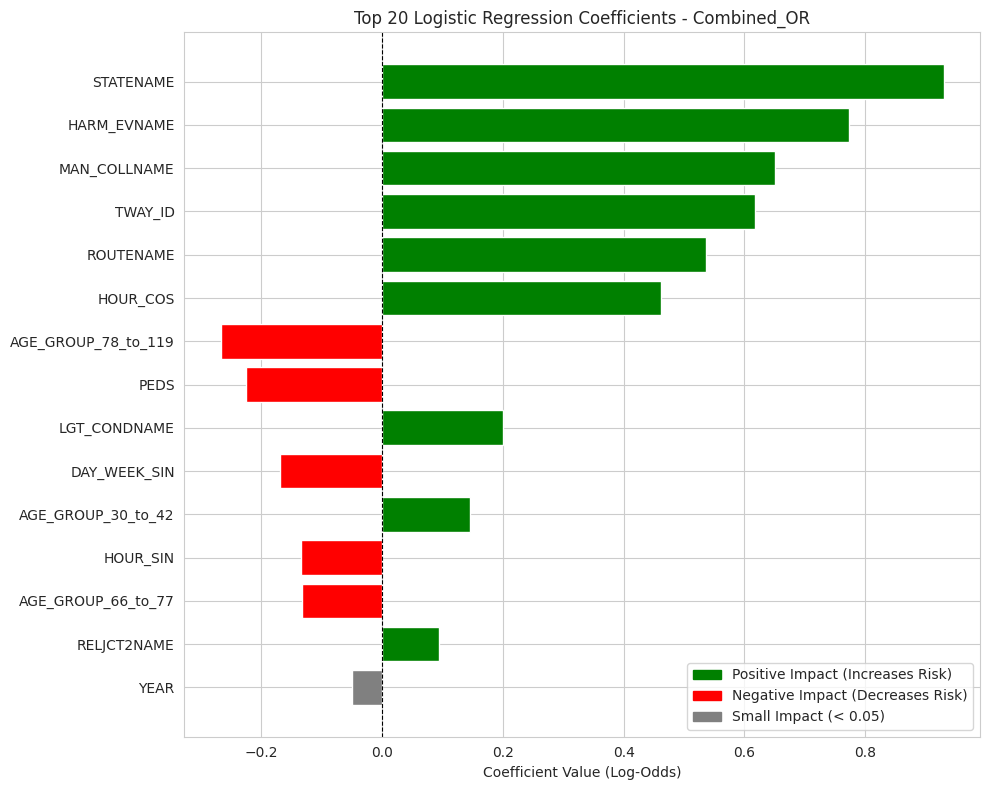

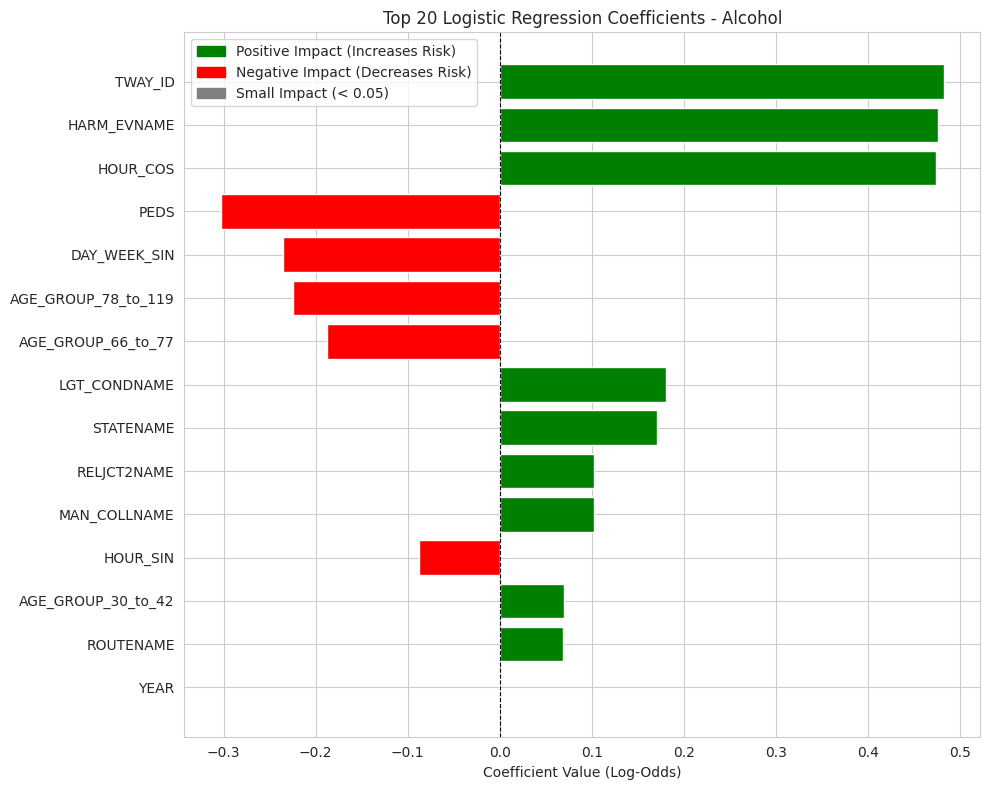

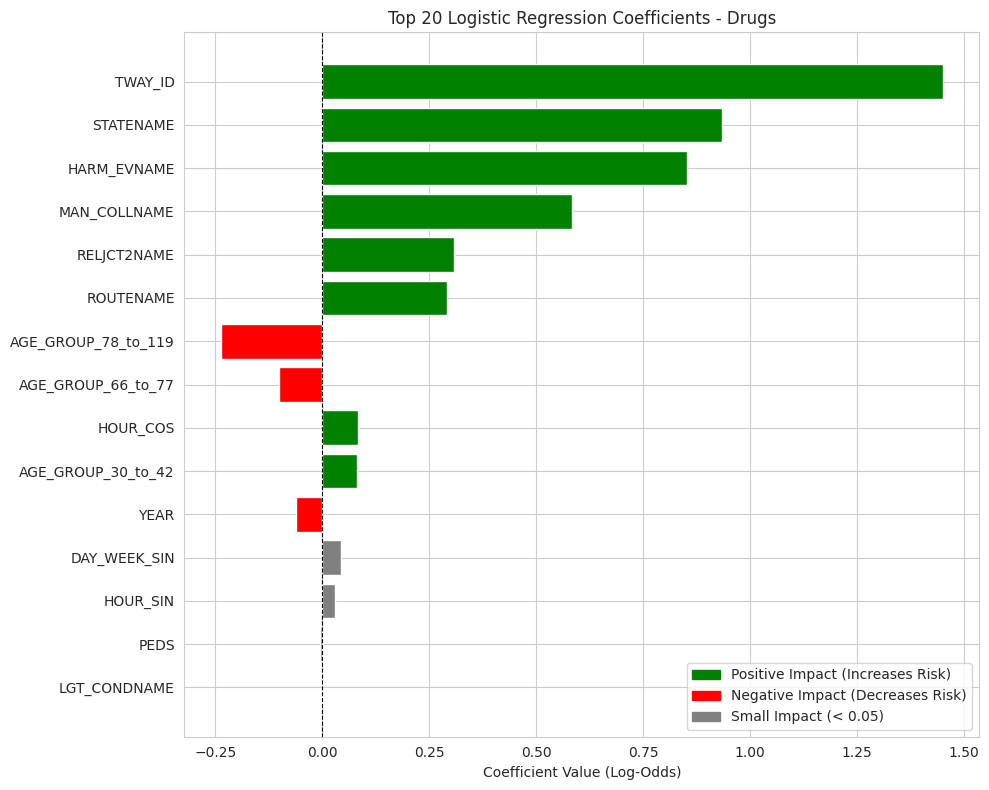

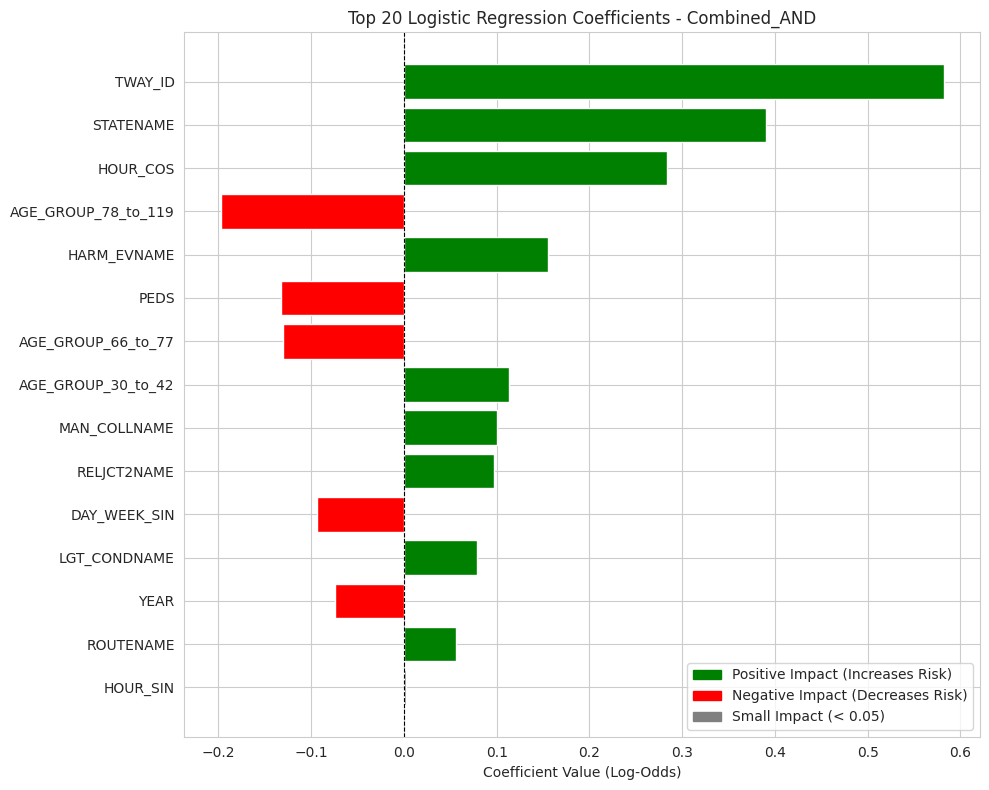

In [ ]:
# Visualize coefficients for Logistic Regression models
import matplotlib.patches as mpatches

# 1. Reconstruct feature names from the original data
# The pipeline loses names because SimpleImputer outputs numpy arrays by default.
# Your ColumnTransformer order was: 1) Numeric, 2) Categorical.
num_cols = X_test_filtered.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_test_filtered.select_dtypes(exclude=np.number).columns.tolist()
reconstructed_names = num_cols + cat_cols

for target_name, models in results.items():
    logreg_model = models['LogReg']
    
    # Extract the classifier step
    classifier = logreg_model.named_steps['classifier']
    
    # 2. Assign Correct Names
    # We verify that the number of columns matches the model's coefficients
    if len(reconstructed_names) == classifier.coef_.shape[1]:
        feature_names = reconstructed_names
    else:
        # Fallback if mismatch (unlikely with WOE, but good for safety)
        print(f"⚠️ Shape mismatch for {target_name}. Using generic names.")
        feature_names = [f"Feat_{i}" for i in range(classifier.coef_.shape[1])]
    
    # Create a DataFrame of coefficients
    coefs_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': classifier.coef_[0]
    })
    
    # Calculate absolute magnitude for sorting (Importance)
    coefs_df['Abs_Coef'] = coefs_df['Coefficient'].abs()
    
    # Sort by absolute magnitude to get the most important features
    coefs_df = coefs_df.sort_values(by='Abs_Coef', ascending=False)
    
    # Select Top 20 features for the plot
    top_n = 20
    plot_df = coefs_df.head(top_n).copy()
    
    # Define Color Logic
    # Green: Positive, Red: Negative, Gray: Very small impact (< 0.05)
    threshold = 0.05
    
    def get_color(val):
        if abs(val) < threshold:
            return 'gray'
        return 'green' if val > 0 else 'red'
    
    colors = plot_df['Coefficient'].apply(get_color)
    
    # Plot
    plt.figure(figsize=(10, 8))
    
    # Invert data so the most important feature is at the top
    plt.barh(plot_df['Feature'][::-1], plot_df['Coefficient'][::-1], color=colors[::-1])
    
    plt.xlabel('Coefficient Value (Log-Odds)')
    plt.title(f'Top {top_n} Logistic Regression Coefficients - {target_name}')
    plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
    
    # Custom Legend
    legend_handles = [
        mpatches.Patch(color='green', label='Positive Impact (Increases Risk)'),
        mpatches.Patch(color='red',   label='Negative Impact (Decreases Risk)'),
        mpatches.Patch(color='gray',  label=f'Small Impact (< {threshold})')
    ]
    plt.legend(handles=legend_handles)
    
    plt.tight_layout()
    plt.show()

### 5.4. Evaluation

In [35]:
test_targets = {
    'Alcohol': y_test['DRUNK_DRIVER'],
    'Drugs': y_test['DRUGGED_DRIVER'],
    'Combined_OR': y_test['DRUG_OR_ALC'], 
    'Combined_AND': y_test['DRUG_&_ALC']
}

# ---------------------------------------------------------
# 3. EVALUATION LOOP
# ---------------------------------------------------------
comparison_data = []

print("\n=== Starting In-Depth Evaluation ===\n")

for target_name, y_true in test_targets.items():
    # Only process if we actually have a trained model for this target
    if target_name not in results:
        print(f"Skipping {target_name} (No model found in results)")
        continue

    print(f"--- Analyzing Target: {target_name} ---")
    
    models = results[target_name]
    
    for model_name, model in models.items():
        # A. Predictions
        # Ensure using the same test features as training
        y_pred = model.predict(X_test_filtered)
        
        # Handle probability (LogReg and XGBoost both support predict_proba)
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test_filtered)[:, 1]
        else:
            y_prob = y_pred # Fallback

        # B. Calculate Metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro') # Macro is better for imbalance
        
        try:
            auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            auc = 0.0

        # C. Store for Comparison Table
        comparison_data.append({
            'Target': target_name,
            'Model': model_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1_Macro': f1,
            'ROC_AUC': auc
        })
        
        # D. Print Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        print(f"\n> {model_name} Results:")
        print(f"  ROC-AUC: {auc:.4f} | F1-Score (Macro): {f1:.4f}")
        print(f"  Confusion Matrix: \n{cm}")
        print("-" * 30)

# ---------------------------------------------------------
# 4. COMPARATIVE ANALYSIS TABLE
# ---------------------------------------------------------
# Convert list to DataFrame for a nice table view
df_comparison = pd.DataFrame(comparison_data)

if not df_comparison.empty:
    # Set index for cleaner display
    df_comparison.set_index(['Target', 'Model'], inplace=True)

    print("\n\n=== FINAL COMPARATIVE ANALYSIS TABLE ===")
    try:
        display(df_comparison)
    except NameError:
        print(df_comparison)

    # Optional: Highlight the "winner" for each target based on ROC_AUC
    print("\n=== BEST MODEL PER TARGET (based on ROC_AUC) ===")
    
    # Reset index to access columns easily for grouping
    df_reset = df_comparison.reset_index()
    loc_indices = df_reset.groupby('Target')['ROC_AUC'].idxmax()
    best_models = df_reset.loc[loc_indices]
    
    try:
        display(best_models[['Target', 'Model', 'ROC_AUC']])
    except NameError:
        print(best_models[['Target', 'Model', 'ROC_AUC']])
else:
    print("No results to display.")


=== Starting In-Depth Evaluation ===

--- Analyzing Target: Alcohol ---

> LogReg Results:
  ROC-AUC: 0.7927 | F1-Score (Macro): 0.6856
  Confusion Matrix: 
[[11688  4231]
 [ 1343  3600]]
------------------------------

> XGBoost Results:
  ROC-AUC: 0.8084 | F1-Score (Macro): 0.6938
  Confusion Matrix: 
[[11753  4166]
 [ 1265  3678]]
------------------------------
--- Analyzing Target: Drugs ---

> LogReg Results:
  ROC-AUC: 0.6368 | F1-Score (Macro): 0.5893
  Confusion Matrix: 
[[8812 5106]
 [2997 3947]]
------------------------------

> XGBoost Results:
  ROC-AUC: 0.6667 | F1-Score (Macro): 0.5901
  Confusion Matrix: 
[[7684 6234]
 [2152 4792]]
------------------------------
--- Analyzing Target: Combined_OR ---

> LogReg Results:
  ROC-AUC: 0.6763 | F1-Score (Macro): 0.6180
  Confusion Matrix: 
[[8721 2464]
 [5178 4499]]
------------------------------

> XGBoost Results:
  ROC-AUC: 0.6745 | F1-Score (Macro): 0.6215
  Confusion Matrix: 
[[8609 2576]
 [5035 4642]]
-------------------

Accuracy  Precision  Recall  F1_Macro  ROC_AUC
Target       Model                                                  
Alcohol      LogReg       0.73       0.46    0.73      0.69     0.79
             XGBoost      0.74       0.47    0.74      0.69     0.81
Drugs        LogReg       0.61       0.44    0.57      0.59     0.64
             XGBoost      0.60       0.43    0.69      0.59     0.67
Combined_OR  LogReg       0.63       0.65    0.46      0.62     0.68
             XGBoost      0.64       0.64    0.48      0.62     0.67
Combined_AND LogReg       0.56       0.17    0.79      0.48     0.73
             XGBoost      0.58       0.18    0.79      0.50     0.75


=== BEST MODEL PER TARGET (based on ROC_AUC) ===


,Target,Model,ROC_AUC
1,Alcohol,XGBoost,0.81
7,Combined_AND,XGBoost,0.75
4,Combined_OR,LogReg,0.68
3,Drugs,XGBoost,0.67


### 5.5. Explainability for Black-Box Model with LIME



=== LIME Explainability for All Targets ===

Explaining Instance Index: 10
Raw Data for this instance:


,TWAY_ID,MAN_COLLNAME,PEDS,RELJCT2NAME,AGE_GROUP_66_to_77,DAY_WEEK_SIN,AGE_GROUP_30_to_42,HOUR_SIN,LGT_CONDNAME,HARM_EVNAME,ROUTENAME,STATENAME,AGE_GROUP_78_to_119,YEAR,HOUR_COS
24422,SR-11,Not a Collision with Motor Vehicle In-Transport,1.00,Non-Junction,0.00,-0.78,0.00,-1.00,Dark - Not Lighted,Pedestrian,State Highway,Oklahoma,0.00,2018.00,-0.00



------------------------------------------------------------
Generating LIME explanation for: Alcohol (XGBoost)
------------------------------------------------------------


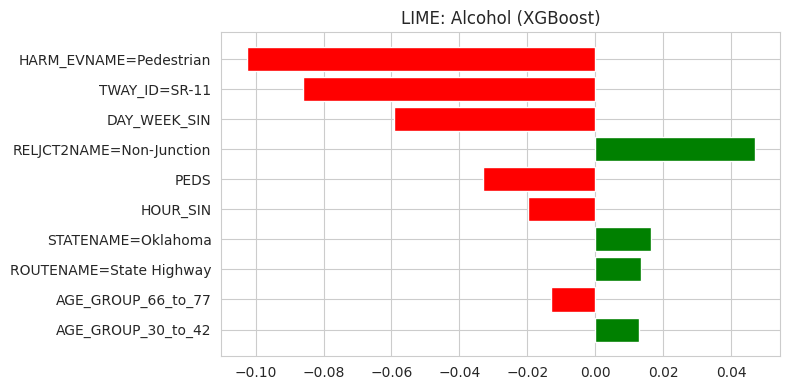


------------------------------------------------------------
Generating LIME explanation for: Drugs (XGBoost)
------------------------------------------------------------


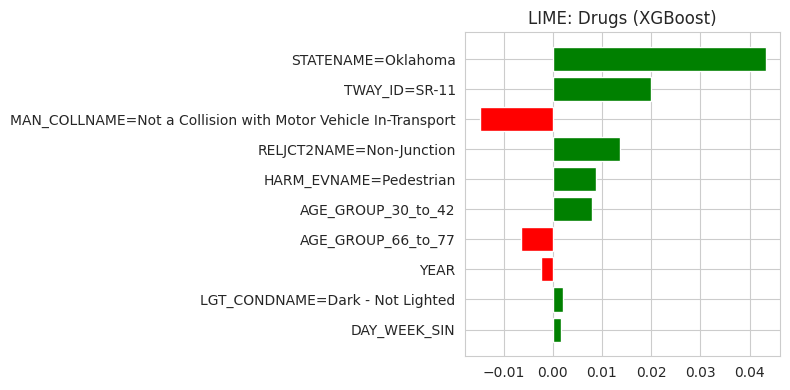


------------------------------------------------------------
Generating LIME explanation for: Combined_OR (XGBoost)
------------------------------------------------------------


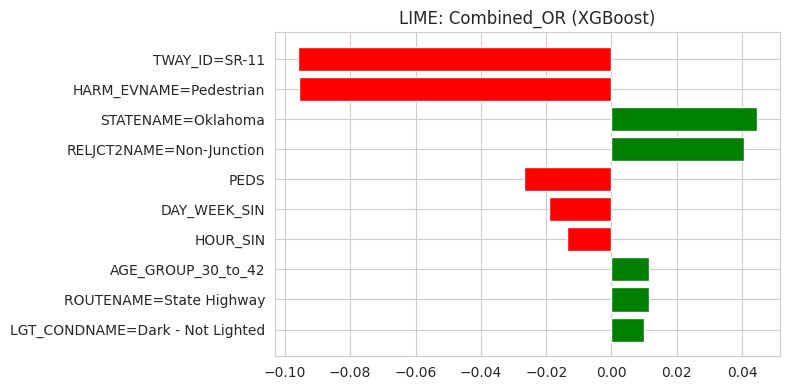


------------------------------------------------------------
Generating LIME explanation for: Combined_AND (XGBoost)
------------------------------------------------------------


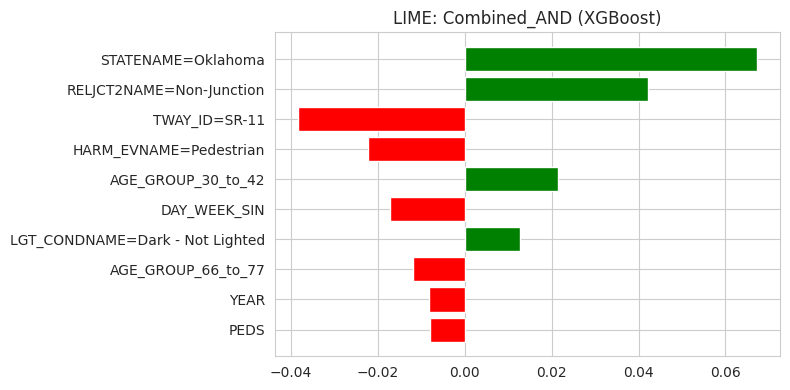

In [43]:
# Explainability with LIME (Loop over all Targets)

print("\n\n=== LIME Explainability for All Targets ===\n")

# 1. DATA PREPARATION (Common for all models)
# ---------------------------------------------------------
def prepare_lime_data(X: pd.DataFrame) -> pd.DataFrame:
    Xc = X.copy()
    for col in Xc.columns:
        if pd.api.types.is_numeric_dtype(Xc[col]) or pd.api.types.is_bool_dtype(Xc[col]):
            # convert nullable numeric/bool -> float with np.nan
            Xc[col] = pd.to_numeric(Xc[col], errors='coerce').astype('float64')
        else:
            # ensure object/string and replace pandas NA with a sentinel string
            Xc[col] = Xc[col].astype('object')
            Xc[col] = Xc[col].where(Xc[col].notna(), 'Missing')
    return Xc

# Prepare data
X_lime_train = prepare_lime_data(X_train_filtered)
X_lime_test = prepare_lime_data(X_test_filtered)

# 2. ENCODING (Common for all models)
# ---------------------------------------------------------
# LIME requires numeric input. We encode strings to integers here, 
# but we must decode them back inside the predict_fn for the pipeline.

categorical_cols = [c for c in X_lime_train.columns if not pd.api.types.is_numeric_dtype(X_lime_train[c])]
categorical_features_idx = [X_lime_train.columns.get_loc(c) for c in categorical_cols]

transformers = {}
categorical_names = {}

X_lime_train_encoded = X_lime_train.copy()
X_lime_test_encoded = X_lime_test.copy()

for col_idx, col_name in zip(categorical_features_idx, categorical_cols):
    le = LabelEncoder()
    le.fit(X_lime_train[col_name].astype(str))
    
    X_lime_train_encoded[col_name] = le.transform(X_lime_train[col_name].astype(str))
    
    categorical_names[col_idx] = le.classes_.tolist()
    transformers[col_idx] = le
    
    def safe_transform(val, encoder):
        s_val = str(val)
        if s_val in encoder.classes_:
            return encoder.transform([s_val])[0]
        return 0 
        
    X_lime_test_encoded[col_name] = X_lime_test[col_name].apply(lambda x: safe_transform(x, le))

# 3. INITIALIZE EXPLAINER (Common)
# ---------------------------------------------------------
explainer = LimeTabularExplainer(
    training_data=X_lime_train_encoded.values.astype(float),
    feature_names=X_lime_train.columns.tolist(),
    class_names=["Not Impaired", "Impaired"],
    categorical_features=categorical_features_idx,
    categorical_names=categorical_names,
    discretize_continuous=False,
    mode="classification",
    random_state=42
)

# Select instance to explain
instance_idx = 10
instance_encoded = X_lime_test_encoded.iloc[instance_idx]

print(f"Explaining Instance Index: {instance_idx}")
print("Raw Data for this instance:")
display(X_lime_test.iloc[instance_idx].to_frame().T)

# 4. LOOP OVER TARGETS
# ---------------------------------------------------------
MODEL_FOR_LIME = "XGBoost"

# Helper factory to create a predict_fn that captures the specific model
def create_predict_fn(model, feature_names, cat_idx, cat_cols, transformers_dict):
    def predict_fn(x_encoded_array: np.ndarray) -> np.ndarray:
        # 1. Reconstruct DataFrame
        df_encoded = pd.DataFrame(x_encoded_array, columns=feature_names)
        
        # 2. Decode categorical columns back to strings
        df_decoded = df_encoded.copy()
        for c_idx, c_name in zip(cat_idx, cat_cols):
            le = transformers_dict[c_idx]
            # LIME generates floats, round to nearest int index
            indices = df_encoded[c_name].values.round().astype(int)
            # Clip to valid range to prevent index errors
            indices = np.clip(indices, 0, len(le.classes_) - 1)
            df_decoded[c_name] = le.inverse_transform(indices)
            
        # 3. Predict using the pipeline
        return model.predict_proba(df_decoded)
    return predict_fn

# Iterate through the keys defined in your test_targets dictionary
for target_name in test_targets.keys():
    print(f"\n{'-'*60}")
    print(f"Generating LIME explanation for: {target_name} ({MODEL_FOR_LIME})")
    print(f"{'-'*60}")
    
    if target_name not in results:
        print(f"Skipping {target_name} (Model not found in results)")
        continue
        
    # 1. Fetch the specific model
    current_model = results[target_name][MODEL_FOR_LIME]
    
    # 2. Create the specific prediction function
    pred_fn = create_predict_fn(
        current_model, 
        X_lime_train.columns, 
        categorical_features_idx, 
        categorical_cols, 
        transformers
    )
    
    # 3. Generate Explanation
    try:
        exp = explainer.explain_instance(
            data_row=instance_encoded.values,
            predict_fn=pred_fn,
            num_features=10
        )
        
        # 4. Plot
        fig = exp.as_pyplot_figure()
        fig.set_size_inches(8, 4)
        plt.title(f"LIME: {target_name} ({MODEL_FOR_LIME})", fontsize=12)
        plt.tight_layout()
        plt.show()
        
        # Optional: Print text summary
        # print(f"Top features for {target_name}:")
        # for feat, val in exp.as_list()[:5]:
        #     print(f"  {feat}: {val:.4f}")
            
    except Exception as e:
        print(f"Error explaining {target_name}: {e}")